In [1]:
################################################
# This python script is designed to take the flight data from
# the sqlite3 database or .csv created in flight-price-api.py and create a model to predict the price
# of flights for any given day, airline and route.

# Thanks!
# Jeremy Beard
################################################

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

from pycaret.regression import *
#from pycaret.time_series import *

from datetime import datetime

In [3]:
dpi = 300
data_dir = "data"
flights_dir = "flight-price-api"
file_path = os.path.join(data_dir, flights_dir)

In [4]:
def GetValues(str):
    print(f"Value counts for {str} column:")
    print(df[str].value_counts())
    print()

In [5]:
# Connect to database
conn = sqlite3.connect(os.path.join(data_dir, flights_dir, "flights.db"))

# Create dataframe from database
df = pd.read_sql_query("SELECT * FROM flights", conn)

In [6]:
# Create various columns from the datetimes!
df['deptDateTime'] = pd.to_datetime(df['deptDateTime'])
df['arrvDateTime'] = pd.to_datetime(df['arrvDateTime'])
df['deptDayOfWeek'] = df['deptDateTime'].dt.day_of_week
df['arrvDayOfWeek'] = df['arrvDateTime'].dt.day_of_week
df['deptMonth'] = df['deptDateTime'].dt.month
df['deptDate'] = df['deptDateTime'].dt.date
df['deptDate'] = pd.to_datetime(df['deptDate'])
df['arrvDate'] = df['arrvDateTime'].dt.date
df['arrvDate'] = pd.to_datetime(df['arrvDate'])
df['deptDayOfYear'] = df['deptDateTime'].dt.dayofyear
df['deptHour'] = df['deptDateTime'].dt.hour
df['deptDayOfMonth'] = df['deptDateTime'].dt.day

Throughout this whole project, I wanted to make sure I got the date-handling correct. 

Using references:

* https://stackoverflow.com/questions/40217369/python-linear-regression-predict-by-date

* 

In [7]:
print(df['deptDateTime'])

0       2023-11-20 20:46:00
1       2023-11-20 09:40:00
2       2023-11-20 05:55:00
3       2023-11-20 17:50:00
4       2023-11-20 09:42:00
                ...        
44946   2024-10-08 12:35:00
44947   2024-10-09 16:45:00
44948   2024-10-09 09:10:00
44949   2024-10-10 16:45:00
44950   2024-10-10 09:10:00
Name: deptDateTime, Length: 44951, dtype: datetime64[ns]


In [8]:
print(df['deptDateTime'][0])

2023-11-20 20:46:00


In [9]:
print(type(df['deptDateTime'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Should we use toordinal()?

In [10]:
def getordinal(x):
    return x.toordinal()

In [11]:
print(df['deptDateTime'][0].toordinal())
df['deptDateTimeOrd'] = df['deptDateTime'].apply(getordinal)

738844


In [12]:
for d8 in range(15):
    print(df['deptDateTime'][d8].toordinal())

738844
738844
738844
738844
738844
738844
738844
738844
738844
738844
738845
738845
738845
738845
738845


Looks like it doesn't account for the time of day, so we'd need to have that as another field.

In [13]:
print(type(df['deptDateTime'][0].toordinal()))

<class 'int'>


Or should we use time.mktime()? time.mktime accounts for the Hour/Minute/Second

In [14]:
print(time.mktime(df['deptDateTime'][0].timetuple()))

1700538360.0


In [15]:
for d8 in range(15):
    print(time.mktime(df['deptDateTime'][d8].timetuple()))

1700538360.0
1700498400.0
1700484900.0
1700527800.0
1700498520.0
1700481600.0
1700490300.0
1700485200.0
1700523360.0
1700549940.0
1700622060.0
1700614200.0
1700584920.0
1700568000.0
1700571600.0


In [16]:
print(type(time.mktime(df['deptDateTime'][0].timetuple())))

<class 'float'>


And should we include day of week as well as a field? Hmm...

In [17]:
print("OG Dataframe info:")
print(df.info())

OG Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44951 entries, 0 to 44950
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   destCode         44951 non-null  object        
 1   destName         44951 non-null  object        
 2   orgCode          44951 non-null  object        
 3   orgName          44951 non-null  object        
 4   deptDateTime     44951 non-null  datetime64[ns]
 5   arrvDateTime     44951 non-null  datetime64[ns]
 6   price            44951 non-null  float64       
 7   currency         44951 non-null  object        
 8   marktName        44951 non-null  object        
 9   marktCode        44951 non-null  object        
 10  optName          44951 non-null  object        
 11  optCode          44951 non-null  object        
 12  flightNum        44951 non-null  object        
 13  duration         44951 non-null  float64       
 14  numConex         44

In [18]:
df.head()

,destCode,destName,orgCode,orgName,deptDateTime,arrvDateTime,price,currency,marktName,marktCode,...,url,deptDayOfWeek,arrvDayOfWeek,deptMonth,deptDate,arrvDate,deptDayOfYear,deptHour,deptDayOfMonth,deptDateTimeOrd
0,CVG,Cincinnati,DEN,Denver,2023-11-20 20:46:00,2023-11-21 01:29:00,55.29,USD,Frontier Airlines,F9,...,https://flights-us.gotogate.com/air/DENCVG20NO...,0,1,11,2023-11-20,2023-11-21,324,20,20,738844
1,CVG,Cincinnati,DEN,Denver,2023-11-20 09:40:00,2023-11-20 14:15:00,95.16,USD,Allegiant Air,G4,...,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20,738844
2,CVG,Cincinnati,DEN,Denver,2023-11-20 05:55:00,2023-11-20 10:38:00,96.45,USD,Frontier Airlines,F9,...,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,5,20,738844
3,CVG,Cincinnati,DEN,Denver,2023-11-20 17:50:00,2023-11-20 22:37:00,138.59,USD,United Airlines,UA,...,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,17,20,738844
4,CVG,Cincinnati,DEN,Denver,2023-11-20 09:42:00,2023-11-20 14:29:00,186.79,USD,United Airlines,UA,...,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20,738844


In [19]:
# We should have NO null values
df.isnull().sum()

destCode           0
destName           0
orgCode            0
orgName            0
deptDateTime       0
arrvDateTime       0
price              0
currency           0
marktName          0
marktCode          0
optName            0
optCode            0
flightNum          0
duration           0
numConex           0
url                0
deptDayOfWeek      0
arrvDayOfWeek      0
deptMonth          0
deptDate           0
arrvDate           0
deptDayOfYear      0
deptHour           0
deptDayOfMonth     0
deptDateTimeOrd    0
dtype: int64

In [20]:
# Get value counts for a lot of columns (next few cells)
GetValues('marktName')


Value counts for marktName column:
United Airlines      28139
American Airlines    12149
Frontier Airlines     2436
Sun Country            656
Air Canada             521
Spirit Airlines        455
Allegiant Air          141
Aeromexico             117
Flair Airlines          53
Alaska Airlines         51
Volaris                 50
WestJet                 48
Lynx Air                47
Key Lime Air            35
Silver Airways          12
Breeze Airways          12
Porter Airlines          7
Canada Jetlines          7
Air Transat              6
Lufthansa                4
LATAM                    3
Air France               1
Icelandair               1
Name: marktName, dtype: int64



In [21]:
GetValues('marktCode')


Value counts for marktCode column:
UA    28139
AA    12149
F9     2436
SY      656
AC      521
NK      455
G4      141
AM      117
F8       53
AS       51
Y4       50
WS       48
Y9       47
KG       35
3M       12
MX       12
PD        7
AU        7
TS        6
LH        4
LA        3
AF        1
FI        1
Name: marktCode, dtype: int64



In [22]:
GetValues('optName')


Value counts for optName column:
United Airlines                       28139
American Airlines                     10474
Frontier Airlines                      2436
Skywest Airlines As American Eagle     1254
Sun Country                             656
Air Canada                              521
Spirit Airlines                         455
Envoy Air As American Eagle             279
Allegiant Air                           141
Aeromexico                              117
Air Wisconsin As American Eagle         105
Psa Airlines As American Eagle           71
Flair Airlines                           53
Volaris                                  50
WestJet                                  48
Lynx Air                                 47
Key Lime Air                             35
Republic Airways As American Eagle       17
Silver Airways                           12
Breeze Airways                           12
Canada Jetlines                           7
Porter Airlines                           7

In [23]:
GetValues('optCode')


Value counts for optCode column:
UA    28139
AA    12200
F9     2436
SY      656
AC      521
NK      455
G4      141
AM      117
F8       53
Y4       50
WS       48
Y9       47
KG       35
3M       12
MX       12
PD        7
AU        7
TS        6
LA        3
LH        3
AF        1
4Y        1
FI        1
Name: optCode, dtype: int64



In [24]:
GetValues('orgName')


Value counts for orgName column:
Denver           22337
New York          3260
Los Angeles       3260
Chicago           3260
San Francisco     3258
Miami             3238
Cincinnati        3224
Orlando           3114
Name: orgName, dtype: int64



In [25]:
GetValues('orgCode')


Value counts for orgCode column:
DEN    22337
NYC     3260
LAX     3260
CHI     3260
SFO     3258
MIA     3238
CVG     3224
ORL     3114
Name: orgCode, dtype: int64



In [26]:
GetValues('destName')


Value counts for destName column:
Denver           22614
Chicago           3260
Los Angeles       3260
New York          3260
San Francisco     3259
Cincinnati        3242
Miami             3238
Orlando           2818
Name: destName, dtype: int64



In [27]:
GetValues('destCode')


Value counts for destCode column:
DEN    22614
CHI     3260
LAX     3260
NYC     3260
SFO     3259
CVG     3242
MIA     3238
ORL     2818
Name: destCode, dtype: int64



In [28]:
GetValues('deptMonth')

Value counts for deptMonth column:
12    4337
3     4319
1     4304
7     4272
5     4251
8     4248
4     4157
6     4128
9     4083
2     4037
11    1540
10    1275
Name: deptMonth, dtype: int64



In [29]:
GetValues('currency')

Value counts for currency column:
USD    44951
Name: currency, dtype: int64



In [30]:
# I saw that the only difference between MARKETING airline and OPERATING airline resided with American Airlines
# So I will drop the optName and optCode columns
# Drop unnecessary columns. We don't care about the codes, about the operating name
df = df.drop(columns=['destCode', 'orgCode', 'optCode', 'marktCode', 'optName'])

# If the currency value counts length is 1 (only USD), then drop the column
if len(df['currency'].value_counts()) == 1:
    print()
    print("Only USD observed in currency column. Dropping column.")
    df = df.drop(columns=['currency'])
    print()


Only USD observed in currency column. Dropping column.



In [31]:
print("Dataframe head:")
print(df.head())

Dataframe head:
     destName orgName        deptDateTime        arrvDateTime   price  \
0  Cincinnati  Denver 2023-11-20 20:46:00 2023-11-21 01:29:00   55.29   
1  Cincinnati  Denver 2023-11-20 09:40:00 2023-11-20 14:15:00   95.16   
2  Cincinnati  Denver 2023-11-20 05:55:00 2023-11-20 10:38:00   96.45   
3  Cincinnati  Denver 2023-11-20 17:50:00 2023-11-20 22:37:00  138.59   
4  Cincinnati  Denver 2023-11-20 09:42:00 2023-11-20 14:29:00  186.79   

           marktName flightNum  duration  numConex  \
0  Frontier Airlines    F94128     163.0         1   
1      Allegiant Air     G4406     155.0         1   
2  Frontier Airlines    F93286     163.0         1   
3    United Airlines    UA1830     167.0         1   
4    United Airlines    UA1978     167.0         1   

                                                 url  deptDayOfWeek  \
0  https://flights-us.gotogate.com/air/DENCVG20NO...              0   
1  https://flights-us.gotogate.com/air/DENCVG20NO...              0   
2  http

In [32]:
print("Dataframe tail:")
print(df.tail())

Dataframe tail:
      destName     orgName        deptDateTime        arrvDateTime   price  \
44946   Denver  Cincinnati 2024-10-08 12:35:00 2024-10-08 17:41:00  598.20   
44947   Denver  Cincinnati 2024-10-09 16:45:00 2024-10-09 17:59:00  170.90   
44948   Denver  Cincinnati 2024-10-09 09:10:00 2024-10-09 10:15:00  190.80   
44949   Denver  Cincinnati 2024-10-10 16:45:00 2024-10-10 17:59:00  247.70   
44950   Denver  Cincinnati 2024-10-10 09:10:00 2024-10-10 10:15:00  251.03   

               marktName flightNum  duration  numConex  \
44946  American Airlines    AA1568     426.0         3   
44947    United Airlines     UA479     194.0         1   
44948    United Airlines     UA497     185.0         1   
44949    United Airlines     UA479     194.0         1   
44950    United Airlines     UA497     185.0         1   

                                                     url  deptDayOfWeek  \
44946  https://flights-us.gotogate.com/air/CVGDEN08OC...              1   
44947  https://f

In [33]:
print("Dataframe describe:")
print(df.describe())

Dataframe describe:
              price      duration      numConex  deptDayOfWeek  arrvDayOfWeek  \
count  44951.000000  44951.000000  44951.000000   44951.000000   44951.000000   
mean     208.218587    265.057685      1.457787       2.989500       2.972837   
std      107.934430    217.025827      0.878563       2.000328       2.000288   
min       24.810000    131.000000      1.000000       0.000000       0.000000   
25%      138.150000    157.000000      1.000000       1.000000       1.000000   
50%      190.970000    217.000000      1.000000       3.000000       3.000000   
75%      243.195000    276.000000      1.000000       5.000000       5.000000   
max     3057.870000   2147.000000      7.000000       6.000000       6.000000   

          deptMonth  deptDayOfYear      deptHour  deptDayOfMonth  \
count  44951.000000   44951.000000  44951.000000    44951.000000   
mean       6.014438     168.136949     12.276412       15.769950   
std        3.351740     102.513778      4.9884

In [34]:
print("Dataframe shape:")
print(df.shape)

Dataframe shape:
(44951, 19)


In [35]:
print("Dataframe columns:")
print(df.columns)

Dataframe columns:
Index(['destName', 'orgName', 'deptDateTime', 'arrvDateTime', 'price',
       'marktName', 'flightNum', 'duration', 'numConex', 'url',
       'deptDayOfWeek', 'arrvDayOfWeek', 'deptMonth', 'deptDate', 'arrvDate',
       'deptDayOfYear', 'deptHour', 'deptDayOfMonth', 'deptDateTimeOrd'],
      dtype='object')


In [36]:
print("Few Columns of Interest: ")
print(df.loc[:, ['orgName', 'destName', 'deptDateTime', 'price']])

Few Columns of Interest: 
          orgName    destName        deptDateTime   price
0          Denver  Cincinnati 2023-11-20 20:46:00   55.29
1          Denver  Cincinnati 2023-11-20 09:40:00   95.16
2          Denver  Cincinnati 2023-11-20 05:55:00   96.45
3          Denver  Cincinnati 2023-11-20 17:50:00  138.59
4          Denver  Cincinnati 2023-11-20 09:42:00  186.79
...           ...         ...                 ...     ...
44946  Cincinnati      Denver 2024-10-08 12:35:00  598.20
44947  Cincinnati      Denver 2024-10-09 16:45:00  170.90
44948  Cincinnati      Denver 2024-10-09 09:10:00  190.80
44949  Cincinnati      Denver 2024-10-10 16:45:00  247.70
44950  Cincinnati      Denver 2024-10-10 09:10:00  251.03

[44951 rows x 4 columns]


In [37]:
print("NEW Dataframe info:")
print(df.info())

NEW Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44951 entries, 0 to 44950
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   destName         44951 non-null  object        
 1   orgName          44951 non-null  object        
 2   deptDateTime     44951 non-null  datetime64[ns]
 3   arrvDateTime     44951 non-null  datetime64[ns]
 4   price            44951 non-null  float64       
 5   marktName        44951 non-null  object        
 6   flightNum        44951 non-null  object        
 7   duration         44951 non-null  float64       
 8   numConex         44951 non-null  int64         
 9   url              44951 non-null  object        
 10  deptDayOfWeek    44951 non-null  int64         
 11  arrvDayOfWeek    44951 non-null  int64         
 12  deptMonth        44951 non-null  int64         
 13  deptDate         44951 non-null  datetime64[ns]
 14  arrvDate         4

In [38]:
plt.style.use('dark_background')
# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

Creating first plot: Price vs. Date


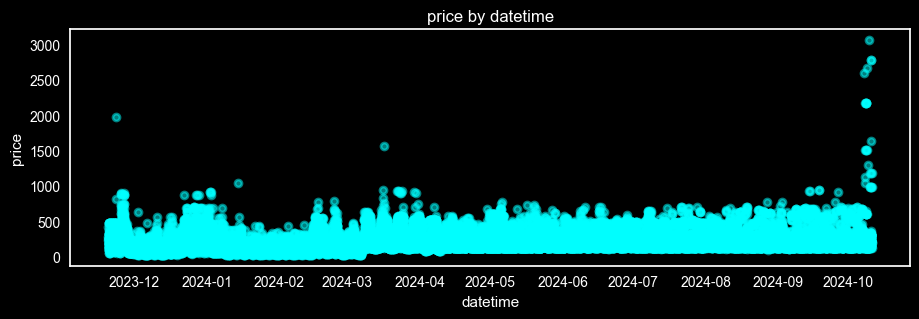

In [39]:
print("Creating first plot: Price vs. Date")

# Set the font size for all text on the plot
plt.rc('font', size=100) 

# Set the font size for the title
#plt.rc('axes', titlesize=15) 

# Set the font size for the x and y labels
#plt.rc('axes', labelsize=15) 

# Set the font size for the x and y tick labels
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15) 

fig0, ax0 = plt.subplots(figsize=(12,6))
df.plot.scatter(x='deptDateTime', y='price', c='cyan', ax=ax0, alpha=0.5, s=25, linewidths=2)
ax0.set(xlabel='datetime', ylabel='price', title='price by datetime')
plt.tight_layout()
plt.grid(False)
plt.show()

Why are the October 2024 prices so high? Let's just remove October 2024, maybe that's too far out

In [40]:
# Create mask
mask = (df['deptDateTime'].dt.month == 10) & (df['deptDateTime'].dt.year == 2024) & (df['deptDateTime'].dt.day > 5)
# Use the mask to drop the rows
df = df[~mask]

Creating first plot again: Price vs. Date


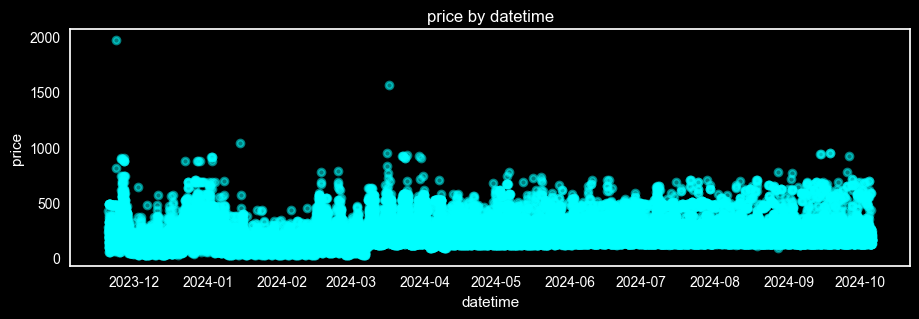

In [41]:
print("Creating first plot again: Price vs. Date")
fig0, ax0 = plt.subplots(figsize=(12,6))
plt.rc('font', size=100) 
#df.plot.scatter(x='deptDateTime', y='price', c='DarkBlue', ax=ax0, alpha=0.1)
df.plot.scatter(x='deptDateTime', y='price', c='cyan', ax=ax0, alpha=0.5, s=25, linewidths=2)
ax0.set(xlabel='datetime', ylabel='price', title='price by datetime')
plt.tight_layout()
plt.grid(False)
plt.show()

#### Let's now explore the data by charting avg. price vs. day of week

In [42]:
# Find mean price by dayOfWeek
df_dow = df.groupby('deptDayOfWeek')
mean_dow = df_dow.mean()
mean_dow = mean_dow.reset_index()

In [43]:
mean_dow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   deptDayOfWeek    7 non-null      int64  
 1   price            7 non-null      float64
 2   duration         7 non-null      float64
 3   numConex         7 non-null      float64
 4   arrvDayOfWeek    7 non-null      float64
 5   deptMonth        7 non-null      float64
 6   deptDayOfYear    7 non-null      float64
 7   deptHour         7 non-null      float64
 8   deptDayOfMonth   7 non-null      float64
 9   deptDateTimeOrd  7 non-null      float64
dtypes: float64(9), int64(1)
memory usage: 688.0 bytes


In [44]:
# Monday=0, Sunday=6
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html
mean_dow.head(10)

,deptDayOfWeek,price,duration,numConex,arrvDayOfWeek,deptMonth,deptDayOfYear,deptHour,deptDayOfMonth,deptDateTimeOrd
0,0,212.924779,256.592184,1.438386,0.061456,5.876458,163.674441,12.587457,15.497321,739000.360542
1,1,176.138508,259.597088,1.465580,1.055389,5.916759,165.218547,12.295616,15.826555,739001.813736
2,2,178.614870,261.592020,1.461126,2.057089,5.948589,166.533512,12.287809,16.180098,739003.181517
3,3,204.576618,271.651090,1.472009,3.066959,5.970989,166.892426,12.043751,15.831425,739003.813392
4,4,218.672087,265.117297,1.451623,4.065391,6.018504,168.000941,12.405363,15.534107,739004.979144
5,5,202.238069,257.950473,1.445426,5.055521,6.032808,168.764353,12.270505,15.851262,739005.404732
6,6,256.776815,285.350566,1.484761,5.519866,5.969363,167.397958,12.034147,16.410882,739003.475028


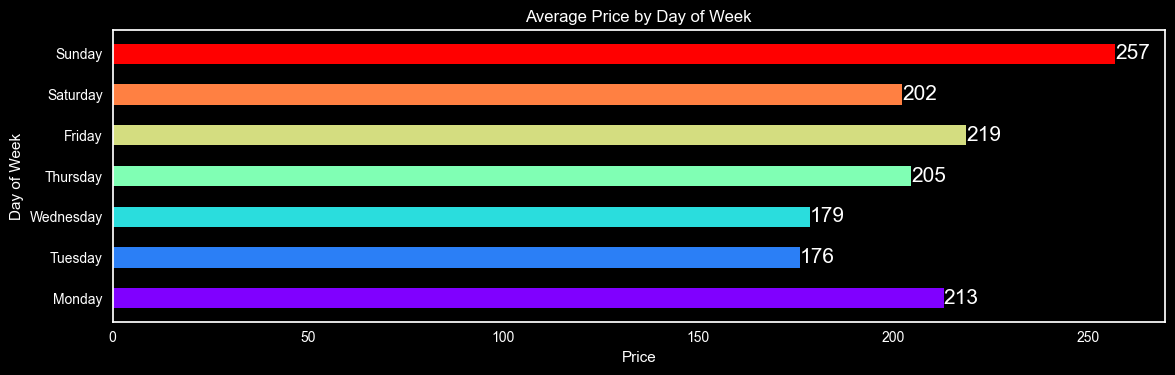

In [45]:
fig1, ax1 = plt.subplots(figsize=(12,4))
plt.rc('font', size=15) 
mean_dow_tmp = mean_dow.drop(columns=['duration', 'numConex', 'arrvDayOfWeek', 'deptMonth'])
daysOfWeek = ['','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a colormap
comap = plt.cm.get_cmap('rainbow', len(mean_dow_tmp['deptDayOfWeek']))

# Assign colors to bars
colors = comap(np.arange(len(mean_dow_tmp['deptDayOfWeek'])))

bars = ax1.barh(mean_dow_tmp['deptDayOfWeek'], mean_dow_tmp['price'], color=colors, height=0.5)
ax1.set(ylabel='Day of Week', xlabel='Price', title='Average Price by Day of Week')
ax1.set_yticklabels(daysOfWeek)
ax1.bar_label(bars, fmt='{:,.0f}', fontsize=15) # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bar_label.html
plt.tight_layout()
plt.grid(False)
plt.show()

#### Let's now explore the data by charting avg. price vs. month

In [46]:
# Find mean price by month
df_mon = df.groupby('deptMonth')
mean_mon = df_mon.mean()
mean_mon = mean_mon.reset_index()
mean_mon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   deptMonth        12 non-null     int64  
 1   price            12 non-null     float64
 2   duration         12 non-null     float64
 3   numConex         12 non-null     float64
 4   deptDayOfWeek    12 non-null     float64
 5   arrvDayOfWeek    12 non-null     float64
 6   deptDayOfYear    12 non-null     float64
 7   deptHour         12 non-null     float64
 8   deptDayOfMonth   12 non-null     float64
 9   deptDateTimeOrd  12 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 1.1 KB


In [47]:
# 1=January, 2=February, etc.
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.month.html
mean_mon.head(12)

,deptMonth,price,duration,numConex,deptDayOfWeek,arrvDayOfWeek,deptDayOfYear,deptHour,deptDayOfMonth,deptDateTimeOrd
0,1,143.680895,257.714219,1.379647,2.813662,2.810409,15.969331,11.876162,15.969331,738900.969331
1,2,151.246061,240.919742,1.345306,3.006440,2.992569,46.028982,12.144166,15.028982,738931.028982
2,3,233.228226,237.239176,1.295439,3.192406,3.158138,76.004399,12.523038,16.004399,738961.004399
3,4,207.390678,268.108732,1.510945,2.841713,2.810440,106.453933,12.422661,15.453933,738991.453933
4,5,216.352733,269.085156,1.544343,3.007763,2.984945,136.999530,12.330981,15.999530,739021.999530
5,6,249.855082,279.130329,1.543605,3.186289,3.151405,167.521318,12.349079,15.521318,739052.521318
6,7,230.331498,270.625000,1.536985,2.802903,2.793305,198.002107,12.267088,16.002107,739083.002107
7,8,227.684463,271.605461,1.534369,3.107580,3.100282,228.967750,12.271422,15.967750,739113.967750
8,9,226.023595,260.462895,1.518246,3.008327,2.998530,259.502327,12.264266,15.502327,739144.502327
9,10,215.398234,269.205499,1.538350,2.985528,3.037627,276.985528,12.247467,2.985528,739161.985528


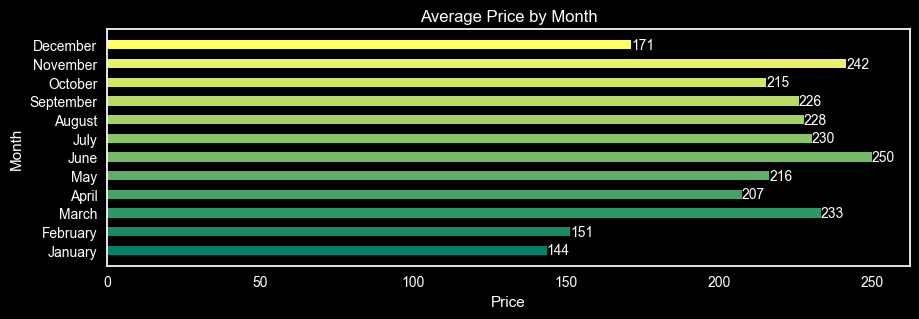

In [48]:
fig2, ax2 = plt.subplots(figsize=(12,6))
plt.rc('font', size=100) 
mean_mon_tmp = mean_mon.drop(columns=['duration', 'numConex', 'deptDayOfWeek', 'arrvDayOfWeek'])
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Create a colormap
comap2 = plt.cm.get_cmap('summer', len(mean_mon_tmp['deptMonth']))

# Assign colors to bars
colors2 = comap2(np.arange(len(mean_mon_tmp['deptMonth'])))

bars = ax2.barh(mean_mon_tmp['deptMonth'], mean_mon_tmp['price'], color=colors2, height=0.5)
ax2.set(ylabel='Month', xlabel='Price', title='Average Price by Month')
ax2.set_yticks(mean_mon_tmp['deptMonth'])
ax2.set_yticklabels(months)
ax2.bar_label(bars, fmt='{:,.0f}', fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.show()

#### Let's now explore the data by charting average flight price vs. day of year

In [49]:
df_doy = df.groupby('deptDayOfYear')['price'].mean()
df_doy = df_doy.reset_index()
df_doy.head(10)



,deptDayOfYear,price
0,1,259.394786
1,2,267.975071
2,3,186.024357
3,4,162.957786
4,5,162.622071
5,6,172.204143
6,7,199.856857
7,8,147.448143
8,9,116.072230
9,10,115.745522


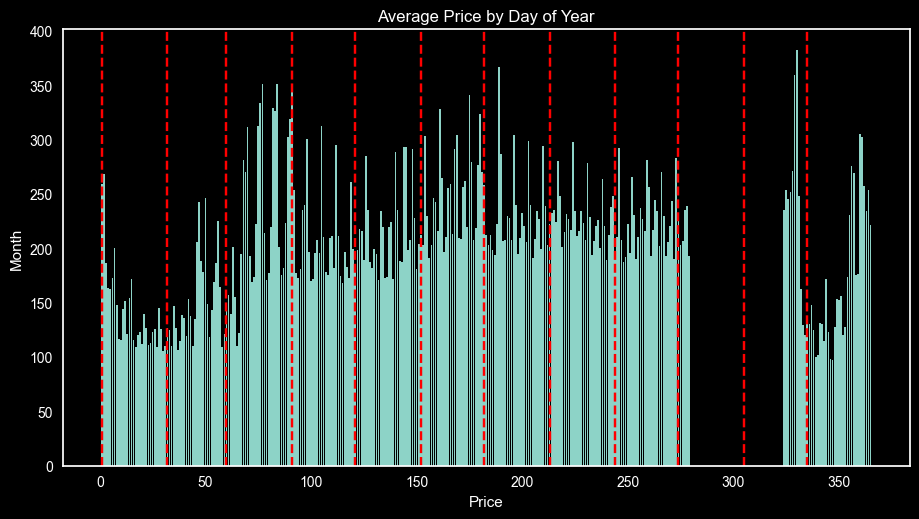

In [50]:
fig3, ax3 = plt.subplots(figsize=(12,8))
plt.rc('font', size=100) 
bars = ax3.bar(df_doy['deptDayOfYear'], df_doy['price'])
ax3.set(ylabel='Month', xlabel='Price', title='Average Price by Day of Year')

# Add vertical lines for the months ( https://stackoverflow.com/questions/71419004/how-to-plot-vertical-lines-at-specific-dates-in-matplotlib )
month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
for day in month_days:
   ax3.axvline(x=day, color='red', linestyle='--')

plt.tight_layout()
plt.grid(False)
plt.show()

I'd like to create the same chart above, but in calendar heatmap form beacuse those look really nice!

https://medium.com/analytics-vidhya/calendar-heatmaps-a-perfect-way-to-display-your-time-series-quantitative-data-ad36bf81a3ed

https://calplot.readthedocs.io/en/latest/index.html

https://matplotlib.org/stable/users/explain/colors/colormaps.html

Let's begin!

In [51]:
df_cal = df.copy()
df_cal.head()

,destName,orgName,deptDateTime,arrvDateTime,price,marktName,flightNum,duration,numConex,url,deptDayOfWeek,arrvDayOfWeek,deptMonth,deptDate,arrvDate,deptDayOfYear,deptHour,deptDayOfMonth,deptDateTimeOrd
0,Cincinnati,Denver,2023-11-20 20:46:00,2023-11-21 01:29:00,55.29,Frontier Airlines,F94128,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,1,11,2023-11-20,2023-11-21,324,20,20,738844
1,Cincinnati,Denver,2023-11-20 09:40:00,2023-11-20 14:15:00,95.16,Allegiant Air,G4406,155.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20,738844
2,Cincinnati,Denver,2023-11-20 05:55:00,2023-11-20 10:38:00,96.45,Frontier Airlines,F93286,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,5,20,738844
3,Cincinnati,Denver,2023-11-20 17:50:00,2023-11-20 22:37:00,138.59,United Airlines,UA1830,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,17,20,738844
4,Cincinnati,Denver,2023-11-20 09:42:00,2023-11-20 14:29:00,186.79,United Airlines,UA1978,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20,738844


In [52]:
df_cal = df_cal[['deptDate', 'price']]
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   deptDate  44367 non-null  datetime64[ns]
 1   price     44367 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


In [53]:
df_cal['deptDate'] = pd.to_datetime(df_cal['deptDate'])

In [54]:
df_cal = df_cal.groupby('deptDate').mean()
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321 entries, 2023-11-20 to 2024-10-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   321 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


In [55]:
df_cal.head(10)

,price
deptDate,
2023-11-20,234.874857
2023-11-21,253.916000
2023-11-22,245.188571
2023-11-23,251.482571
2023-11-24,270.612571
2023-11-25,358.938071
2023-11-26,382.092929
2023-11-27,247.859071
2023-11-28,162.324714


In [56]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321 entries, 2023-11-20 to 2024-10-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   321 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB


In [57]:
import calplot
print(type(df_cal.index))
# The index should be a DatetimeIndex for calplot

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


(<Figure size 1250x340 with 3 Axes>,
 array([<Axes: ylabel='2023'>, <Axes: ylabel='2024'>], dtype=object))

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


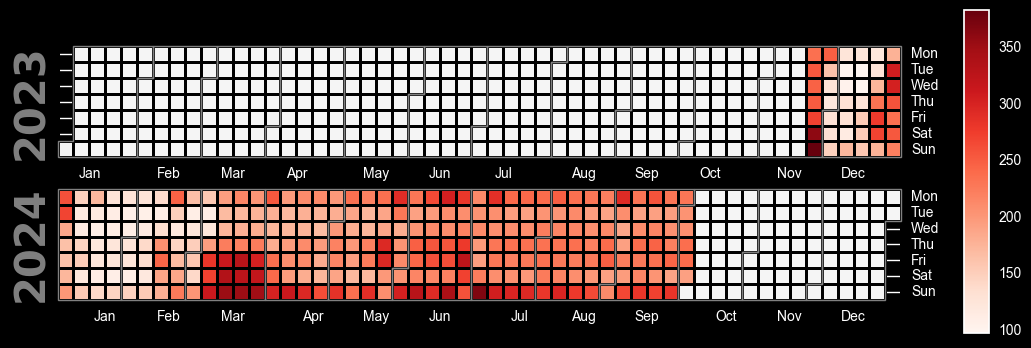

In [58]:
calplot.calplot(df_cal['price'], cmap='Reds', colorbar=True, textformat=None) # textformat='{:.0f}')

What about the calendar plot using the july package?

https://medium.com/analytics-vidhya/calendar-heatmaps-a-perfect-way-to-display-your-time-series-quantitative-data-ad36bf81a3ed

https://pypi.org/project/july/

In [59]:
!pip install july

In [60]:
#july.calendar_plot(dates, df1['SALES'], cmap = 'copper');
import july
#july.calendar_plot(df_cal, cmap = 'copper')
df_jul = df.copy()
df_jul = df_jul[['deptDate', 'price']]
df_jul.head(15)

,deptDate,price
0,2023-11-20,55.29
1,2023-11-20,95.16
2,2023-11-20,96.45
3,2023-11-20,138.59
4,2023-11-20,186.79
5,2023-11-20,141.53
6,2023-11-20,141.53
7,2023-11-20,141.53
8,2023-11-20,192.26
9,2023-11-20,195.61


In [61]:
df_jul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   deptDate  44367 non-null  datetime64[ns]
 1   price     44367 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


In [62]:
df_jul['deptDate'] = pd.to_datetime(df_jul['deptDate'])
df_jul = df_jul.groupby('deptDate').mean()
df_jul = df_jul.reset_index()
df_jul.head(15)

,deptDate,price
0,2023-11-20,234.874857
1,2023-11-21,253.916000
2,2023-11-22,245.188571
3,2023-11-23,251.482571
4,2023-11-24,270.612571
5,2023-11-25,358.938071
6,2023-11-26,382.092929
7,2023-11-27,247.859071
8,2023-11-28,162.324714
9,2023-11-29,129.147786


In [63]:
df_jul.tail(15)

,deptDate,price
306,2024-09-21,202.416058
307,2024-09-22,269.919778
308,2024-09-23,229.740821
309,2024-09-24,192.987778
310,2024-09-25,205.891765
311,2024-09-26,220.678788
312,2024-09-27,243.742899
313,2024-09-28,190.180827
314,2024-09-29,282.844599
315,2024-09-30,228.955985


In [64]:
df_jul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   deptDate  321 non-null    datetime64[ns]
 1   price     321 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.1 KB


array([[<Axes: title={'center': 'November'}>,
        <Axes: title={'center': 'December'}>,
        <Axes: title={'center': 'January'}>,
        <Axes: title={'center': 'February'}>],
       [<Axes: title={'center': 'March'}>,
        <Axes: title={'center': 'April'}>,
        <Axes: title={'center': 'May'}>,
        <Axes: title={'center': 'June'}>],
       [<Axes: title={'center': 'July'}>,
        <Axes: title={'center': 'August'}>,
        <Axes: title={'center': 'September'}>,
        <Axes: title={'center': 'October'}>]], dtype=object)

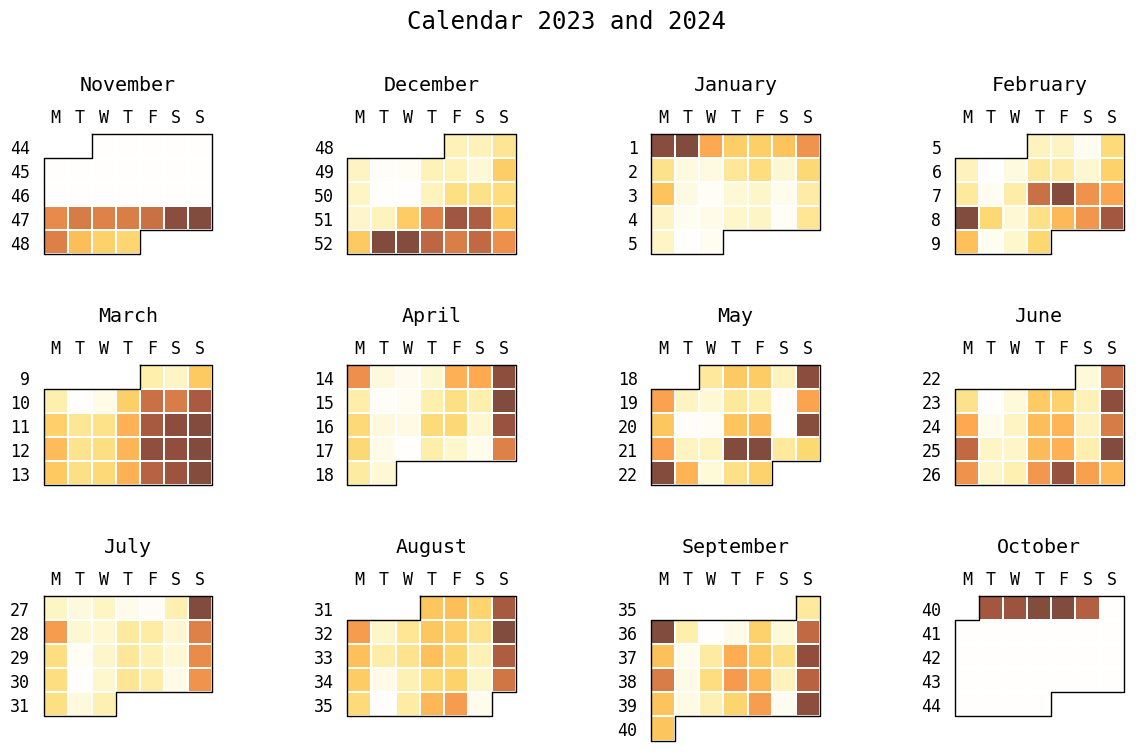

In [65]:
plt.style.use('default')
july.calendar_plot(df_jul['deptDate'], df_jul['price'], cmap = 'golden')

#### Let's now explore the data by charting average flight price vs. hour of day

In [66]:
# Find mean price by hour
df_hr = df.groupby('deptHour')
mean_hr = df_hr.mean()
mean_hr = mean_hr.reset_index()
mean_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   deptHour         21 non-null     int64  
 1   price            21 non-null     float64
 2   duration         21 non-null     float64
 3   numConex         21 non-null     float64
 4   deptDayOfWeek    21 non-null     float64
 5   arrvDayOfWeek    21 non-null     float64
 6   deptMonth        21 non-null     float64
 7   deptDayOfYear    21 non-null     float64
 8   deptDayOfMonth   21 non-null     float64
 9   deptDateTimeOrd  21 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 1.8 KB


In [67]:
mean_hr.head(24)

,deptHour,price,duration,numConex,deptDayOfWeek,arrvDayOfWeek,deptMonth,deptDayOfYear,deptDayOfMonth,deptDateTimeOrd
0,0,198.537173,225.138520,1.030361,2.963947,2.963947,5.851992,163.481973,16.119545,738968.833017
1,1,88.750000,225.000000,1.000000,4.000000,4.000000,2.333333,54.000000,13.333333,738939.000000
2,5,190.912104,253.836174,1.834087,3.074435,3.072696,6.055304,169.376348,15.772174,739008.291130
3,6,187.704626,247.673737,1.466001,3.019339,3.017779,5.901747,164.856519,15.913911,739000.104492
4,7,209.693897,266.735380,1.401939,3.116963,3.113409,5.906947,165.029402,15.933764,738996.959935
5,8,209.051216,243.268307,1.458939,3.116513,3.108509,6.137267,171.941891,15.847317,739005.541061
6,9,216.392712,235.181239,1.230051,3.070883,3.043718,5.553905,154.486418,16.122666,738998.741511
7,10,227.043197,330.741685,1.941685,2.945572,2.958963,5.902376,164.593952,15.606911,738991.414687
8,11,242.124816,288.542832,1.291084,3.107955,3.098776,6.034965,168.941871,15.956731,739010.231206
9,12,220.527629,285.922811,1.668051,2.913811,2.908619,5.776393,160.902042,15.757009,739013.811353


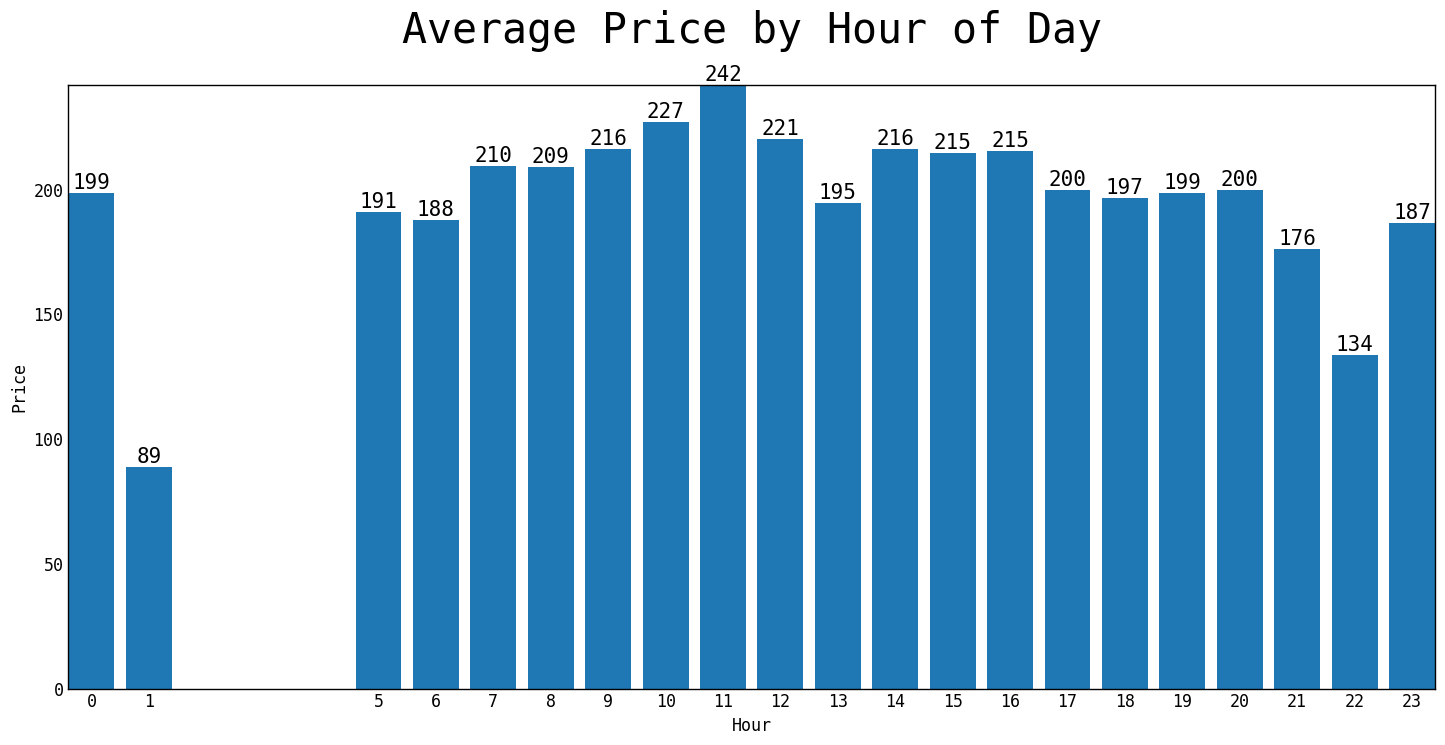

In [68]:
fig4, ax4 = plt.subplots(figsize=(15,8))
plt.rc('font', size=25) 
mean_hr_tmp = mean_hr.drop(columns=['duration', 'numConex', 'deptDayOfWeek', 'arrvDayOfWeek', 'deptMonth', 'deptDayOfYear'])
#months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
bars = ax4.bar(mean_hr_tmp['deptHour'], mean_hr_tmp['price'])
ax4.set(xlabel='Hour', ylabel='Price', title='Average Price by Hour of Day')
ax4.set_xticks(mean_hr_tmp['deptHour'])
#ax4.set_yticklabels(months)
ax4.bar_label(bars, fmt='{:,.0f}', fontsize=15)
plt.tight_layout()
plt.show()

#### Now let's start with the machine learning models

Let's see, what features and what targets do we want...

From a few articles:

* https://datascience.stackexchange.com/questions/2368/machine-learning-features-engineering-from-date-time-data
* https://datascience.stackexchange.com/questions/112357/feature-engineering-for-datetime-column

It seems like popular features are dayOfWeek, dayOfMonth, dayOfYear, hour, and month. This is what we will use.

##### Features

* deptDayOfWeek
* deptDayOfMonth
* deptDayOfYear
* deptHour
* deptMonth
* marktName
* orgName
* destName

##### Targets

* price


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   destName         44367 non-null  object        
 1   orgName          44367 non-null  object        
 2   deptDateTime     44367 non-null  datetime64[ns]
 3   arrvDateTime     44367 non-null  datetime64[ns]
 4   price            44367 non-null  float64       
 5   marktName        44367 non-null  object        
 6   flightNum        44367 non-null  object        
 7   duration         44367 non-null  float64       
 8   numConex         44367 non-null  int64         
 9   url              44367 non-null  object        
 10  deptDayOfWeek    44367 non-null  int64         
 11  arrvDayOfWeek    44367 non-null  int64         
 12  deptMonth        44367 non-null  int64         
 13  deptDate         44367 non-null  datetime64[ns]
 14  arrvDate         44367 non-null  datet

In [70]:
df.head(15)

,destName,orgName,deptDateTime,arrvDateTime,price,marktName,flightNum,duration,numConex,url,deptDayOfWeek,arrvDayOfWeek,deptMonth,deptDate,arrvDate,deptDayOfYear,deptHour,deptDayOfMonth,deptDateTimeOrd
0,Cincinnati,Denver,2023-11-20 20:46:00,2023-11-21 01:29:00,55.29,Frontier Airlines,F94128,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,1,11,2023-11-20,2023-11-21,324,20,20,738844
1,Cincinnati,Denver,2023-11-20 09:40:00,2023-11-20 14:15:00,95.16,Allegiant Air,G4406,155.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20,738844
2,Cincinnati,Denver,2023-11-20 05:55:00,2023-11-20 10:38:00,96.45,Frontier Airlines,F93286,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,5,20,738844
3,Cincinnati,Denver,2023-11-20 17:50:00,2023-11-20 22:37:00,138.59,United Airlines,UA1830,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,17,20,738844
4,Cincinnati,Denver,2023-11-20 09:42:00,2023-11-20 14:29:00,186.79,United Airlines,UA1978,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20,738844
5,Cincinnati,Denver,2023-11-20 05:00:00,2023-11-20 12:27:00,141.53,American Airlines,AA2612,327.0,3,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,5,20,738844
6,Cincinnati,Denver,2023-11-20 07:25:00,2023-11-20 15:54:00,141.53,American Airlines,AA852,389.0,3,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,7,20,738844
7,Cincinnati,Denver,2023-11-20 06:00:00,2023-11-20 15:54:00,141.53,American Airlines,AA1067,474.0,3,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,6,20,738844
8,Cincinnati,Denver,2023-11-20 16:36:00,2023-11-20 23:59:00,192.26,American Airlines,AA1832,323.0,3,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,16,20,738844
9,Cincinnati,Denver,2023-11-20 23:59:00,2023-11-21 12:29:00,195.61,Spirit Airlines,NK1320,630.0,3,https://flights-us.gotogate.com/air/DENCVG20NO...,0,1,11,2023-11-20,2023-11-21,324,23,20,738844


In [71]:
features = df[['deptDayOfWeek', 'deptDayOfMonth', 'deptDayOfYear', 'deptHour', 'deptMonth', 'marktName', 'orgName', 'destName']]
print(features)

       deptDayOfWeek  deptDayOfMonth  deptDayOfYear  deptHour  deptMonth  \
0                  0              20            324        20         11   
1                  0              20            324         9         11   
2                  0              20            324         5         11   
3                  0              20            324        17         11   
4                  0              20            324         9         11   
...              ...             ...            ...       ...        ...   
44912              5               5            279         7         10   
44913              5               5            279        12         10   
44914              5               5            279        12         10   
44915              5               5            279        20         10   
44916              5               5            279        16         10   

               marktName     orgName    destName  
0      Frontier Airlines      Denver

In [72]:
targets = df[['price']]
print(targets)

        price
0       55.29
1       95.16
2       96.45
3      138.59
4      186.79
...       ...
44912  192.20
44913  192.20
44914  192.20
44915  192.20
44916  192.20

[44367 rows x 1 columns]


<Axes: >

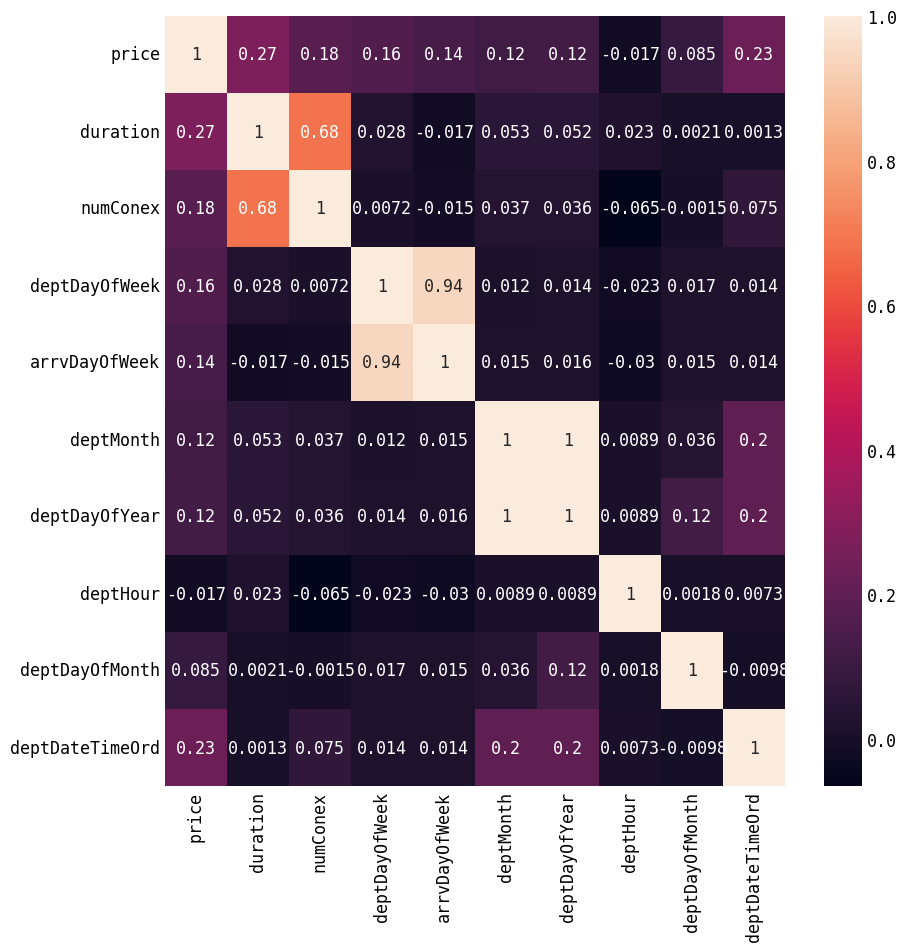

In [73]:
#plot the correlations between features and targets
plt.rc('font', size=12) 
f = plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

All of the above heatmap definitely makes sense:

* duration strongly positively correlated to numConex
* arrival day strongly corresponds with departure day 

Now I need to create some dummy variables. 

I had some thought too about whether month, dayOfWeek, etc. were numerical or categorical....

Monday=0, Tuesday=1, etc... but Tuesday is not bigger than Monday. 

https://www.reddit.com/r/learnpython/comments/chunas/correlation_with_day_of_week/

https://mikulskibartosz.name/time-in-machine-learning  

This might be a loooooooot of dummy variables...

In [74]:
# Get the dummies and store it in a variable
#dummies = pd.get_dummies(features['marktName'])
features_dum = pd.get_dummies(features, columns=['marktName', 'orgName', 'destName', 'deptDayOfWeek'])
features_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   deptDayOfMonth               44367 non-null  int64
 1   deptDayOfYear                44367 non-null  int64
 2   deptHour                     44367 non-null  int64
 3   deptMonth                    44367 non-null  int64
 4   marktName_Aeromexico         44367 non-null  uint8
 5   marktName_Air Canada         44367 non-null  uint8
 6   marktName_Air Transat        44367 non-null  uint8
 7   marktName_Alaska Airlines    44367 non-null  uint8
 8   marktName_Allegiant Air      44367 non-null  uint8
 9   marktName_American Airlines  44367 non-null  uint8
 10  marktName_Breeze Airways     44367 non-null  uint8
 11  marktName_Canada Jetlines    44367 non-null  uint8
 12  marktName_Flair Airlines     44367 non-null  uint8
 13  marktName_Frontier Airlines  44367 non-null  u

In [75]:
#split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features_dum, targets, test_size=0.22, random_state=23)
print("x_train")
print(x_train)
print("x_test")
print(x_test)
print("y_train")
print(y_train)
print("y_test")
print(y_test)
#default size is 25% test size

x_train
       deptDayOfMonth  deptDayOfYear  deptHour  deptMonth  \
34054              17            169        15          6   
2418               18            200        14          7   
11475               9            130         7          5   
42628              18             49         9          2   
27043              17            108        17          4   
...               ...            ...       ...        ...   
9836               27            331        15         11   
11322              24            115        14          4   
26886               1             92        12          4   
9338               29            242         7          8   
42105              27            361         9         12   

       marktName_Aeromexico  marktName_Air Canada  marktName_Air Transat  \
34054                     0                     0                      0   
2418                      0                     0                      0   
11475                     0    

In [76]:
#use at least one ML model to fit to the training data
#create the model first, then fit it to training data
lr_model = LinearRegression().fit(x_train, y_train)
#lr_model = lr_model.fit(x_train, y_train)

In [77]:
# https://realpython.com/linear-regression-in-python/
y_predictions = lr_model.predict(x_test)

In [78]:
# Calculate mean squared error
mse = mean_squared_error(y_test, y_predictions)
print("Mean Squared Error:", mse)



Mean Squared Error: 6129.733066683015


In [79]:
# Calculate R-squared
r2 = r2_score(y_test, y_predictions)
print("R-squared:", r2)

R-squared: 0.3866250808600583


In [80]:
r_sq = lr_model.score(x_train, y_train)
print(f'R-squared again: {r_sq}')

R-squared again: 0.39676132785277063


In [81]:
mae = mean_absolute_error(y_test, y_predictions)

print('Mean Absolute Error:', mae)

Mean Absolute Error: 54.67673555693131


So after creating our features_dum and targets for our test LinearRegression model, we want to move onto pycaret.

Before we do that though, I'm going to concatenate our features_dum and targets (well, target) into one dataframe, df_dum

In [82]:
df_dum = pd.concat([features_dum, targets], axis='columns')

In [83]:
df_dum.columns

Index(['deptDayOfMonth', 'deptDayOfYear', 'deptHour', 'deptMonth',
       'marktName_Aeromexico', 'marktName_Air Canada', 'marktName_Air Transat',
       'marktName_Alaska Airlines', 'marktName_Allegiant Air',
       'marktName_American Airlines', 'marktName_Breeze Airways',
       'marktName_Canada Jetlines', 'marktName_Flair Airlines',
       'marktName_Frontier Airlines', 'marktName_Key Lime Air',
       'marktName_LATAM', 'marktName_Lynx Air', 'marktName_Porter Airlines',
       'marktName_Silver Airways', 'marktName_Spirit Airlines',
       'marktName_Sun Country', 'marktName_United Airlines',
       'marktName_Volaris', 'marktName_WestJet', 'orgName_Chicago',
       'orgName_Cincinnati', 'orgName_Denver', 'orgName_Los Angeles',
       'orgName_Miami', 'orgName_New York', 'orgName_Orlando',
       'orgName_San Francisco', 'destName_Chicago', 'destName_Cincinnati',
       'destName_Denver', 'destName_Los Angeles', 'destName_Miami',
       'destName_New York', 'destName_Orlando', 'd

In [84]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   deptDayOfMonth               44367 non-null  int64  
 1   deptDayOfYear                44367 non-null  int64  
 2   deptHour                     44367 non-null  int64  
 3   deptMonth                    44367 non-null  int64  
 4   marktName_Aeromexico         44367 non-null  uint8  
 5   marktName_Air Canada         44367 non-null  uint8  
 6   marktName_Air Transat        44367 non-null  uint8  
 7   marktName_Alaska Airlines    44367 non-null  uint8  
 8   marktName_Allegiant Air      44367 non-null  uint8  
 9   marktName_American Airlines  44367 non-null  uint8  
 10  marktName_Breeze Airways     44367 non-null  uint8  
 11  marktName_Canada Jetlines    44367 non-null  uint8  
 12  marktName_Flair Airlines     44367 non-null  uint8  
 13  marktName_Fronti

In [85]:
df_dum.head(10)

,deptDayOfMonth,deptDayOfYear,deptHour,deptMonth,marktName_Aeromexico,marktName_Air Canada,marktName_Air Transat,marktName_Alaska Airlines,marktName_Allegiant Air,marktName_American Airlines,...,destName_Orlando,destName_San Francisco,deptDayOfWeek_0,deptDayOfWeek_1,deptDayOfWeek_2,deptDayOfWeek_3,deptDayOfWeek_4,deptDayOfWeek_5,deptDayOfWeek_6,price
0,20,324,20,11,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,55.29
1,20,324,9,11,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,95.16
2,20,324,5,11,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,96.45
3,20,324,17,11,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,138.59
4,20,324,9,11,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,186.79
5,20,324,5,11,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,141.53
6,20,324,7,11,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,141.53
7,20,324,6,11,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,141.53
8,20,324,16,11,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,192.26
9,20,324,23,11,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,195.61


## Pycaret Model 1: Parsed Time, KFold Generator

#### Now I want to use pycarat to compare ml models

https://www.pycaret.org/tutorials/html/REG101.html

https://pycaret.readthedocs.io/en/latest/api/regression.html

I don't really understand the default 'fold' parameter of 10 but it seems to be related to computational power. I will stick with the default of 10. 

"Reducing the number of folds will improve the training time."

In [86]:
reg1 = setup(data = df_dum, target = 'price', session_id=23)

,Description,Value
0,Session id,23
1,Target,price
2,Target type,Regression
3,Original data shape,"(44367, 48)"
4,Transformed data shape,"(44367, 48)"
5,Transformed train set shape,"(31056, 48)"
6,Transformed test set shape,"(13311, 48)"
7,Numeric features,47
8,Preprocess,True
9,Imputation type,simple


In [87]:
best = compare_models(n_select=4, exclude="auto_arima")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,22.3922,1738.2994,41.5714,0.8287,0.1681,0.1099,6.2470
et,Extra Trees Regressor,22.2305,1872.4788,43.1010,0.8158,0.1758,0.1100,6.0910
lightgbm,Light Gradient Boosting Machine,32.3108,2519.4096,50.1319,0.7515,0.2108,0.1644,0.3270
dt,Decision Tree Regressor,25.6773,2982.4714,54.4355,0.7057,0.2140,0.1214,0.1770
gbr,Gradient Boosting Regressor,45.2813,4465.6951,66.7875,0.5591,0.2847,0.2371,1.9240
knn,K Neighbors Regressor,49.8493,5658.2161,75.1728,0.4418,0.3229,0.2637,0.4350
lr,Linear Regression,53.9990,6122.7636,78.2216,0.3951,0.3613,0.3046,0.8110
br,Bayesian Ridge,53.9890,6122.9232,78.2227,0.3951,0.3612,0.3045,0.1360
ridge,Ridge Regression,53.9794,6124.6803,78.2341,0.3949,0.3611,0.3046,0.0750
lasso,Lasso Regression,58.4987,7137.1279,84.4442,0.2954,0.3856,0.3387,0.0830


The pycaret Linear Regression results track with our former Linear Regression that we performed ourselves!

Looks like Random Forest is the best model according to Mean Squared Error, Root Mean Squared Error, and R^2 value.

Let's go with that. I also want to create a Decision Tree and K-Nearest Neighbor model to compare.

#### Random Forest

In [88]:
model_rf = create_model('rf')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,21.4681,1478.6607,38.4534,0.8430,0.1630,0.1066
1,22.8740,1704.0184,41.2798,0.8400,0.1699,0.1110
2,22.4565,1572.5232,39.6551,0.8431,0.1685,0.1093
3,22.6916,1691.9252,41.1330,0.8136,0.1710,0.1142
4,22.8040,1880.2239,43.3615,0.8124,0.1723,0.1086
5,21.3979,1492.2430,38.6296,0.8475,0.1654,0.1078
6,22.5436,2387.7590,48.8647,0.7842,0.1679,0.1077
7,23.3817,2044.7517,45.2189,0.8069,0.1720,0.1139
8,21.8471,1623.6780,40.2949,0.8371,0.1612,0.1069


In [89]:
evaluate_model(model_rf)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [90]:

new_data = pd.DataFrame({'deptDayOfWeek': [0], 'deptDayOfMonth': [27], 'deptDayOfYear': ['2023-11-27'], 
                         'deptHour': [10], 'deptMonth': [11], 'marktName_Aeromexico': [0], 'marktName_Air Canada': [0], 
                         'marktName_Air Transat': [0], 'marktName_Alaska Airlines': [0], 'marktName_Allegiant Air': [0], 
                         'marktName_American Airlines': [0], 'marktName_Breeze Airways': [0], 'marktName_Canada Jetlines': [0], 
                         'marktName_Flair Airlines': [0], 'marktName_Frontier Airlines': [0], 'marktName_Key Lime Air': [0], 
                         'marktName_LATAM': [0], 'marktName_Lynx Air': [0], 'marktName_Porter Airlines': [0], 
                         'marktName_Silver Airways': [0], 'marktName_Spirit Airlines': [0], 'marktName_Sun Country': [0], 
                         'marktName_United Airlines': [1], 'marktName_Volaris': [0], 'marktName_WestJet': [0], 
                         'orgName_Chicago': [0], 'orgName_Cincinnati': [0], 'orgName_Denver': [1], 'orgName_Los Angeles': [0], 
                         'orgName_Miami': [0], 'orgName_New York': [0], 'orgName_Orlando': [0], 'orgName_San Francisco': [0], 
                         'destName_Chicago': [0], 'destName_Cincinnati': [1], 'destName_Denver': [0], 'destName_Los Angeles': [0], 
                         'destName_Miami': [0], 'destName_New York': [0], 'destName_Orlando': [0], 'destName_San Francisco': [0],
                         'deptDayOfWeek_0': [1], 'deptDayOfWeek_1': [0], 'deptDayOfWeek_2': [0], 'deptDayOfWeek_3': [0], 
                         'deptDayOfWeek_4': [0], 'deptDayOfWeek_5': [0], 'deptDayOfWeek_6': [0]})

new_data['deptDayOfYear'] = pd.to_datetime(new_data['deptDayOfYear'])
new_data['deptDayOfYear'] = new_data['deptDayOfYear'].dt.dayofyear

predictions = predict_model(model_rf, data = new_data)


In [91]:
print(predictions['prediction_label'])

0    264.464202
Name: prediction_label, dtype: float64


In [92]:
predictions = predict_model(model_rf, data = x_test)

In [93]:
preds = predictions['prediction_label']
preds.head()

16381     87.653002
23903    179.715905
27446    222.719013
20403    427.968006
16495     78.578001
Name: prediction_label, dtype: float64

In [94]:
print(f'R2 Score: {r2_score(y_test, preds)}')

R2 Score: 0.8440041624094571


#### Extra Tree Regressor

In [95]:
model_et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,21.4089,1578.5004,39.7303,0.8324,0.1700,0.1071
1,22.6758,1848.9770,42.9997,0.8264,0.1765,0.1105
2,22.3096,1705.5651,41.2985,0.8299,0.1752,0.1085
3,22.1988,1575.0341,39.6867,0.8265,0.1754,0.1123
4,23.3304,2091.3530,45.7313,0.7913,0.1859,0.1138
5,21.3780,1589.1883,39.8646,0.8376,0.1724,0.1087
6,22.2317,2533.8371,50.3372,0.7711,0.1736,0.1060
7,23.3222,2446.0959,49.4580,0.7690,0.1824,0.1149
8,21.4539,1763.6041,41.9953,0.8231,0.1690,0.1067


In [96]:
evaluate_model(model_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### K-Nearest Neighbor

In [97]:
model_knn = create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,49.0095,5200.4512,72.1142,0.4479,0.3176,0.2602
1,51.8882,6225.9072,78.9044,0.4156,0.3306,0.2693
2,50.2068,5517.0532,74.2769,0.4497,0.3205,0.2630
3,49.0377,5051.8066,71.0761,0.4434,0.3223,0.2665
4,49.4602,5488.2041,74.0824,0.4523,0.3152,0.2544
5,49.1159,5444.3452,73.7858,0.4438,0.3335,0.2740
6,48.9467,6167.6343,78.5343,0.4427,0.3122,0.2533
7,50.7686,6007.2153,77.5062,0.4327,0.3296,0.2673
8,48.5615,5498.1953,74.1498,0.4484,0.3139,0.2540


In [98]:
evaluate_model(model_knn)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Light Gradient Boosting Machine

In [99]:
model_lgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.0688,2341.1349,48.3853,0.7514,0.2098,0.1639
1,32.5116,2546.6116,50.4640,0.7610,0.2084,0.1629
2,32.2599,2322.8398,48.1958,0.7683,0.2077,0.1636
3,32.4749,2256.9601,47.5075,0.7513,0.2140,0.1673
4,32.8542,2758.7849,52.5241,0.7247,0.2157,0.1639
5,31.3629,2277.7269,47.7255,0.7673,0.2103,0.1641
6,32.1217,3110.0358,55.7677,0.7190,0.2042,0.1593
7,33.0853,2707.3990,52.0327,0.7443,0.2152,0.1675
8,32.1866,2461.3481,49.6120,0.7531,0.2063,0.1645


In [100]:
evaluate_model(model_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Pycaret Model 2: Parsed + Ordinate Time, KFold Generator

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   destName         44367 non-null  object        
 1   orgName          44367 non-null  object        
 2   deptDateTime     44367 non-null  datetime64[ns]
 3   arrvDateTime     44367 non-null  datetime64[ns]
 4   price            44367 non-null  float64       
 5   marktName        44367 non-null  object        
 6   flightNum        44367 non-null  object        
 7   duration         44367 non-null  float64       
 8   numConex         44367 non-null  int64         
 9   url              44367 non-null  object        
 10  deptDayOfWeek    44367 non-null  int64         
 11  arrvDayOfWeek    44367 non-null  int64         
 12  deptMonth        44367 non-null  int64         
 13  deptDate         44367 non-null  datetime64[ns]
 14  arrvDate         44367 non-null  datet

In [102]:
features2 = df[['deptDateTimeOrd', 'deptDayOfWeek', 'deptHour', 'deptMonth', 'marktName', 'orgName', 'destName']]
targets2 = df[['price']]

In [103]:
features2_dum = pd.get_dummies(features2, columns=['marktName', 'orgName', 'destName', 'deptDayOfWeek'])
features2_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   deptDateTimeOrd              44367 non-null  int64
 1   deptHour                     44367 non-null  int64
 2   deptMonth                    44367 non-null  int64
 3   marktName_Aeromexico         44367 non-null  uint8
 4   marktName_Air Canada         44367 non-null  uint8
 5   marktName_Air Transat        44367 non-null  uint8
 6   marktName_Alaska Airlines    44367 non-null  uint8
 7   marktName_Allegiant Air      44367 non-null  uint8
 8   marktName_American Airlines  44367 non-null  uint8
 9   marktName_Breeze Airways     44367 non-null  uint8
 10  marktName_Canada Jetlines    44367 non-null  uint8
 11  marktName_Flair Airlines     44367 non-null  uint8
 12  marktName_Frontier Airlines  44367 non-null  uint8
 13  marktName_Key Lime Air       44367 non-null  u

In [104]:
df_dum2 = pd.concat([features2_dum, targets2], axis='columns')

In [105]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(features2_dum, targets2, test_size=0.22, random_state=23)

In [106]:
reg2 = setup(data = df_dum2, target = 'price', session_id=23)

,Description,Value
0,Session id,23
1,Target,price
2,Target type,Regression
3,Original data shape,"(44367, 47)"
4,Transformed data shape,"(44367, 47)"
5,Transformed train set shape,"(31056, 47)"
6,Transformed test set shape,"(13311, 47)"
7,Numeric features,46
8,Preprocess,True
9,Imputation type,simple


In [107]:
best2 = compare_models(n_select=4, exclude="auto_arima")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,22.0532,1717.3270,41.3090,0.8309,0.1659,0.1076,5.5570
et,Extra Trees Regressor,22.2147,1858.2160,42.9357,0.8172,0.1758,0.1095,5.7720
lightgbm,Light Gradient Boosting Machine,32.2642,2553.3294,50.4808,0.7480,0.2124,0.1646,0.4090
dt,Decision Tree Regressor,25.3544,2852.1946,53.3291,0.7184,0.2118,0.1194,0.1960
gbr,Gradient Boosting Regressor,45.2910,4463.4364,66.7732,0.5593,0.2837,0.2374,1.9960
knn,K Neighbors Regressor,47.4499,5246.6422,72.3906,0.4823,0.3085,0.2495,0.4490
lr,Linear Regression,53.8426,6130.1808,78.2659,0.3944,0.3546,0.2978,0.1240
ridge,Ridge Regression,53.8520,6130.5599,78.2685,0.3944,0.3546,0.2979,0.0820
br,Bayesian Ridge,53.8478,6130.3442,78.2670,0.3944,0.3546,0.2979,0.1630
lasso,Lasso Regression,58.1187,6978.8266,83.5009,0.3111,0.3743,0.3267,0.0840


In [108]:
model_rf2 = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,21.1546,1414.0188,37.6034,0.8499,0.1610,0.1047
1,22.2905,1615.3289,40.1912,0.8484,0.1673,0.1079
2,22.4011,1572.6652,39.6568,0.8431,0.1669,0.1075
3,22.2372,1601.5141,40.0189,0.8235,0.1671,0.1114
4,22.4817,1902.4926,43.6176,0.8101,0.1703,0.1064
5,21.4428,1535.8340,39.1897,0.8431,0.1649,0.1068
6,22.2789,2384.6629,48.8330,0.7845,0.1658,0.1054
7,22.8589,2045.1897,45.2238,0.8069,0.1694,0.1105
8,21.3360,1582.6828,39.7829,0.8412,0.1583,0.1046


In [109]:
evaluate_model(model_rf2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [110]:
x_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9761 entries, 16381 to 10324
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   deptDateTimeOrd              9761 non-null   int64
 1   deptHour                     9761 non-null   int64
 2   deptMonth                    9761 non-null   int64
 3   marktName_Aeromexico         9761 non-null   uint8
 4   marktName_Air Canada         9761 non-null   uint8
 5   marktName_Air Transat        9761 non-null   uint8
 6   marktName_Alaska Airlines    9761 non-null   uint8
 7   marktName_Allegiant Air      9761 non-null   uint8
 8   marktName_American Airlines  9761 non-null   uint8
 9   marktName_Breeze Airways     9761 non-null   uint8
 10  marktName_Canada Jetlines    9761 non-null   uint8
 11  marktName_Flair Airlines     9761 non-null   uint8
 12  marktName_Frontier Airlines  9761 non-null   uint8
 13  marktName_Key Lime Air       9761 non-null 

In [111]:
x_test2.head()

,deptDateTimeOrd,deptHour,deptMonth,marktName_Aeromexico,marktName_Air Canada,marktName_Air Transat,marktName_Alaska Airlines,marktName_Allegiant Air,marktName_American Airlines,marktName_Breeze Airways,...,destName_New York,destName_Orlando,destName_San Francisco,deptDayOfWeek_0,deptDayOfWeek_1,deptDayOfWeek_2,deptDayOfWeek_3,deptDayOfWeek_4,deptDayOfWeek_5,deptDayOfWeek_6
16381,738854,0,11,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
23903,739000,8,4,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
27446,739036,8,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
20403,738974,10,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
16495,738865,0,12,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [112]:
predictions2 = predict_model(model_rf2, data = x_test2)

In [113]:
predictions2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9761 entries, 16381 to 10324
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   deptDateTimeOrd              9761 non-null   int32  
 1   deptHour                     9761 non-null   int8   
 2   deptMonth                    9761 non-null   int8   
 3   marktName_Aeromexico         9761 non-null   uint8  
 4   marktName_Air Canada         9761 non-null   uint8  
 5   marktName_Air Transat        9761 non-null   uint8  
 6   marktName_Alaska Airlines    9761 non-null   uint8  
 7   marktName_Allegiant Air      9761 non-null   uint8  
 8   marktName_American Airlines  9761 non-null   uint8  
 9   marktName_Breeze Airways     9761 non-null   uint8  
 10  marktName_Canada Jetlines    9761 non-null   uint8  
 11  marktName_Flair Airlines     9761 non-null   uint8  
 12  marktName_Frontier Airlines  9761 non-null   uint8  
 13  marktName_Key

In [114]:
predictions2.head()

,deptDateTimeOrd,deptHour,deptMonth,marktName_Aeromexico,marktName_Air Canada,marktName_Air Transat,marktName_Alaska Airlines,marktName_Allegiant Air,marktName_American Airlines,marktName_Breeze Airways,...,destName_Orlando,destName_San Francisco,deptDayOfWeek_0,deptDayOfWeek_1,deptDayOfWeek_2,deptDayOfWeek_3,deptDayOfWeek_4,deptDayOfWeek_5,deptDayOfWeek_6,prediction_label
16381,738854,0,11,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,80.297802
23903,739000,8,4,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,173.063239
27446,739036,8,5,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,219.882828
20403,738974,10,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,441.724607
16495,738865,0,12,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,78.581000


In [115]:
y_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9761 entries, 16381 to 10324
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   9761 non-null   float64
dtypes: float64(1)
memory usage: 152.5 KB


In [116]:
y_test2.head()

,price
16381,96.26
23903,172.71
27446,229.22
20403,290.09
16495,91.23


In [117]:
preds2 = predictions2['prediction_label']
preds2.head()

16381     80.297802
23903    173.063239
27446    219.882828
20403    441.724607
16495     78.581000
Name: prediction_label, dtype: float64

In [118]:
print(f'R2 Score: {r2_score(y_test2, preds2)}')

R2 Score: 0.8432711378301447


In [119]:
new_data2 = pd.DataFrame({'deptDateTimeOrd': ['2024-11-27'], 
                         'deptHour': [10], 'deptMonth': [11], 'marktName_Aeromexico': [0], 'marktName_Air Canada': [0], 
                         'marktName_Air Transat': [0], 'marktName_Alaska Airlines': [0], 'marktName_Allegiant Air': [0], 
                         'marktName_American Airlines': [0], 'marktName_Breeze Airways': [0], 'marktName_Canada Jetlines': [0], 
                         'marktName_Flair Airlines': [0], 'marktName_Frontier Airlines': [0], 'marktName_Key Lime Air': [0], 
                         'marktName_LATAM': [0], 'marktName_Lynx Air': [0], 'marktName_Porter Airlines': [0], 
                         'marktName_Silver Airways': [0], 'marktName_Spirit Airlines': [0], 'marktName_Sun Country': [0], 
                         'marktName_United Airlines': [1], 'marktName_Volaris': [0], 'marktName_WestJet': [0], 
                         'orgName_Chicago': [0], 'orgName_Cincinnati': [0], 'orgName_Denver': [1], 'orgName_Los Angeles': [0], 
                         'orgName_Miami': [0], 'orgName_New York': [0], 'orgName_Orlando': [0], 'orgName_San Francisco': [0], 
                         'destName_Chicago': [0], 'destName_Cincinnati': [1], 'destName_Denver': [0], 'destName_Los Angeles': [0], 
                         'destName_Miami': [0], 'destName_New York': [0], 'destName_Orlando': [0], 'destName_San Francisco': [0],
                         'deptDayOfWeek_0': [1], 'deptDayOfWeek_1': [0], 'deptDayOfWeek_2': [0], 'deptDayOfWeek_3': [0], 
                         'deptDayOfWeek_4': [0], 'deptDayOfWeek_5': [0], 'deptDayOfWeek_6': [0]})

new_data2['deptDateTimeOrd'] = pd.to_datetime(new_data2['deptDateTimeOrd'])
new_data2['deptDateTimeOrd'] = new_data2['deptDateTimeOrd'].apply(getordinal)


prediction2 = predict_model(model_rf2, data = new_data2)
print(new_data2.iloc[0])

deptDateTimeOrd                739217
deptHour                           10
deptMonth                          11
marktName_Aeromexico                0
marktName_Air Canada                0
marktName_Air Transat               0
marktName_Alaska Airlines           0
marktName_Allegiant Air             0
marktName_American Airlines         0
marktName_Breeze Airways            0
marktName_Canada Jetlines           0
marktName_Flair Airlines            0
marktName_Frontier Airlines         0
marktName_Key Lime Air              0
marktName_LATAM                     0
marktName_Lynx Air                  0
marktName_Porter Airlines           0
marktName_Silver Airways            0
marktName_Spirit Airlines           0
marktName_Sun Country               0
marktName_United Airlines           1
marktName_Volaris                   0
marktName_WestJet                   0
orgName_Chicago                     0
orgName_Cincinnati                  0
orgName_Denver                      1
orgName_Los 

In [120]:
print(prediction2['prediction_label'])

0    277.763306
Name: prediction_label, dtype: float64


In [121]:
def make2digit(num):
    if len(num) < 2:
        return '0' + num
    return num

In [122]:
df_input = pd.DataFrame({'deptDateTimeOrd': [''], 
                         'deptHour': [0], 'deptMonth': ['1'], 'marktName_Aeromexico': [0], 'marktName_Air Canada': [0], 
                         'marktName_Air Transat': [0], 'marktName_Alaska Airlines': [0], 'marktName_Allegiant Air': [0], 
                         'marktName_American Airlines': [0], 'marktName_Breeze Airways': [0], 'marktName_Canada Jetlines': [0], 
                         'marktName_Flair Airlines': [0], 'marktName_Frontier Airlines': [0], 'marktName_Key Lime Air': [0], 
                         'marktName_LATAM': [0], 'marktName_Lynx Air': [0], 'marktName_Porter Airlines': [0], 
                         'marktName_Silver Airways': [0], 'marktName_Spirit Airlines': [0], 'marktName_Sun Country': [0], 
                         'marktName_United Airlines': [0], 'marktName_Volaris': [0], 'marktName_WestJet': [0], 
                         'orgName_Chicago': [0], 'orgName_Cincinnati': [0], 'orgName_Denver': [1], 'orgName_Los Angeles': [0], 
                         'orgName_Miami': [0], 'orgName_New York': [0], 'orgName_Orlando': [0], 'orgName_San Francisco': [0], 
                         'destName_Chicago': [0], 'destName_Cincinnati': [0], 'destName_Denver': [0], 'destName_Los Angeles': [0], 
                         'destName_Miami': [0], 'destName_New York': [0], 'destName_Orlando': [0], 'destName_San Francisco': [0],
                         'deptDayOfWeek_0': [0], 'deptDayOfWeek_1': [0], 'deptDayOfWeek_2': [0], 'deptDayOfWeek_3': [0], 
                         'deptDayOfWeek_4': [0], 'deptDayOfWeek_5': [0], 'deptDayOfWeek_6': [0]})

In [123]:
year = input("Enter the year (####): ")
month = input("Enter the month (1-12): ")
day = input("Enter the day (1-31): ")
airline = input("Enter the airline: ")
origin = input("Enter the origin: ")
destination = input("Enter the destination: ")
hour_of_day = int(input("Enter the hour of day (0-23): "))

Enter the year (####): 2024
Enter the month (1-12): 12
Enter the day (1-31): 22
Enter the airline: United Airlines
Enter the origin: Denver
Enter the destination: Cincinnati
Enter the hour of day (0-23): 6


In [124]:
input_datetime = year + '-' + make2digit(month) + '-' + make2digit(day)
input_datetime = pd.to_datetime(input_datetime)
input_ord_datetime = getordinal(input_datetime)
input_day_of_week = input_datetime.day_of_week
print(f"Selected {input_datetime}, Day of Week is {input_day_of_week}")

Selected 2024-12-22 00:00:00, Day of Week is 6


In [125]:
print(type(input_day_of_week))

<class 'int'>


In [126]:
airline = 'marktName_' + airline
print(airline)

marktName_United Airlines


In [127]:
origin = 'orgName_' + origin
print(origin)

orgName_Denver


In [128]:
destination = 'destName_' + destination
print(destination)

destName_Cincinnati


In [129]:
input_day_of_week = 'deptDayOfWeek_' + str(input_day_of_week)
print(input_day_of_week)

deptDayOfWeek_6


In [130]:
df_input = pd.DataFrame({'deptDateTimeOrd': [input_ord_datetime], 
                         'deptHour': [hour_of_day], 'deptMonth': [make2digit(month)], 
                         'marktName_Aeromexico': [int('marktName_Aeromexico'==airline)], 
                         'marktName_Air Canada': [int('marktName_Air Canada'==airline)], 
                         'marktName_Air Transat': [int('marktName_Air Transat'==airline)], 
                         'marktName_Alaska Airlines': [int('marktName_Alaska Airlines'==airline)], 
                         'marktName_Allegiant Air': [int('marktName_Allegiant Air'==airline)], 
                         'marktName_American Airlines': [int('marktName_American Airlines'==airline)], 
                         'marktName_Breeze Airways': [int('marktName_Breeze Airways'==airline)], 
                         'marktName_Canada Jetlines': [int('marktName_Canada Jetlines'==airline)], 
                         'marktName_Flair Airlines': [int('marktName_Flair Airlines'==airline)], 
                         'marktName_Frontier Airlines': [int('marktName_Frontier Airlines'==airline)], 
                         'marktName_Key Lime Air': [int('marktName_Key Lime Air'==airline)], 
                         'marktName_LATAM': [int('marktName_LATAM'==airline)], 
                         'marktName_Lynx Air': [int('marktName_Lynx Air'==airline)], 
                         'marktName_Porter Airlines': [int('marktName_Porter Airlines'==airline)], 
                         'marktName_Silver Airways': [int('marktName_Silver Airways'==airline)], 
                         'marktName_Spirit Airlines': [int('marktName_Spirit Airlines'==airline)], 
                         'marktName_Sun Country': [int('marktName_Sun Country'==airline)], 
                         'marktName_United Airlines': [int('marktName_United Airlines'==airline)], 
                         'marktName_Volaris': [int('marktName_Volaris'==airline)], 
                         'marktName_WestJet': [int('marktName_WestJet'==airline)], 
                         'orgName_Chicago': [int('orgName_Chicago'==origin)], 
                         'orgName_Cincinnati': [int('orgName_Cincinnati'==origin)], 
                         'orgName_Denver': [int('orgName_Denver'==origin)], 
                         'orgName_Los Angeles': [int('orgName_Los Angeles'==origin)], 
                         'orgName_Miami': [int('orgName_Miami'==origin)], 
                         'orgName_New York': [int('orgName_New York'==origin)], 
                         'orgName_Orlando': [int('orgName_Orlando'==origin)], 
                         'orgName_San Francisco': [int('orgName_San Francisco'==origin)], 
                         'destName_Chicago': [int('destName_Chicago'==destination)], 
                         'destName_Cincinnati': [int('destName_Cincinnati'==destination)], 
                         'destName_Denver': [int('destName_Denver'==destination)], 
                         'destName_Los Angeles': [int('destName_Los Angeles'==destination)], 
                         'destName_Miami': [int('destName_Miami'==destination)], 
                         'destName_New York': [int('destName_New York'==destination)], 
                         'destName_Orlando': [int('destName_Orlando'==destination)], 
                         'destName_San Francisco': [int('destName_San Francisco'==destination)],
                         'deptDayOfWeek_0': [int('deptDayOfWeek_0'==input_day_of_week)], 
                         'deptDayOfWeek_1': [int('deptDayOfWeek_1'==input_day_of_week)], 
                         'deptDayOfWeek_2': [int('deptDayOfWeek_2'==input_day_of_week)], 
                         'deptDayOfWeek_3': [int('deptDayOfWeek_3'==input_day_of_week)], 
                         'deptDayOfWeek_4': [int('deptDayOfWeek_4'==input_day_of_week)], 
                         'deptDayOfWeek_5': [int('deptDayOfWeek_5'==input_day_of_week)], 
                         'deptDayOfWeek_6': [int('deptDayOfWeek_6'==input_day_of_week)]})

print(df_input.iloc[0])

deptDateTimeOrd                739242
deptHour                            6
deptMonth                          12
marktName_Aeromexico                0
marktName_Air Canada                0
marktName_Air Transat               0
marktName_Alaska Airlines           0
marktName_Allegiant Air             0
marktName_American Airlines         0
marktName_Breeze Airways            0
marktName_Canada Jetlines           0
marktName_Flair Airlines            0
marktName_Frontier Airlines         0
marktName_Key Lime Air              0
marktName_LATAM                     0
marktName_Lynx Air                  0
marktName_Porter Airlines           0
marktName_Silver Airways            0
marktName_Spirit Airlines           0
marktName_Sun Country               0
marktName_United Airlines           1
marktName_Volaris                   0
marktName_WestJet                   0
orgName_Chicago                     0
orgName_Cincinnati                  0
orgName_Denver                      1
orgName_Los 

In [131]:
input_prediction = predict_model(model_rf2, data = df_input)

In [132]:
print(input_prediction['prediction_label'])

0    170.315099
Name: prediction_label, dtype: float64


## Pycaret Model 3: DateTime, TimeSeries Generator

Now let's do Time Series! What does our data look like again?

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   destName         44367 non-null  object        
 1   orgName          44367 non-null  object        
 2   deptDateTime     44367 non-null  datetime64[ns]
 3   arrvDateTime     44367 non-null  datetime64[ns]
 4   price            44367 non-null  float64       
 5   marktName        44367 non-null  object        
 6   flightNum        44367 non-null  object        
 7   duration         44367 non-null  float64       
 8   numConex         44367 non-null  int64         
 9   url              44367 non-null  object        
 10  deptDayOfWeek    44367 non-null  int64         
 11  arrvDayOfWeek    44367 non-null  int64         
 12  deptMonth        44367 non-null  int64         
 13  deptDate         44367 non-null  datetime64[ns]
 14  arrvDate         44367 non-null  datet

In [134]:
df.head()

,destName,orgName,deptDateTime,arrvDateTime,price,marktName,flightNum,duration,numConex,url,deptDayOfWeek,arrvDayOfWeek,deptMonth,deptDate,arrvDate,deptDayOfYear,deptHour,deptDayOfMonth,deptDateTimeOrd
0,Cincinnati,Denver,2023-11-20 20:46:00,2023-11-21 01:29:00,55.29,Frontier Airlines,F94128,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,1,11,2023-11-20,2023-11-21,324,20,20,738844
1,Cincinnati,Denver,2023-11-20 09:40:00,2023-11-20 14:15:00,95.16,Allegiant Air,G4406,155.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20,738844
2,Cincinnati,Denver,2023-11-20 05:55:00,2023-11-20 10:38:00,96.45,Frontier Airlines,F93286,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,5,20,738844
3,Cincinnati,Denver,2023-11-20 17:50:00,2023-11-20 22:37:00,138.59,United Airlines,UA1830,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,17,20,738844
4,Cincinnati,Denver,2023-11-20 09:42:00,2023-11-20 14:29:00,186.79,United Airlines,UA1978,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20,738844


For this time series, we want the following:

Features:

* destName

* orgName

* marktName

* deptDateTime

* deptDayOfWeek

Targets:

* price



I think that's it for now

In [135]:
time_features = df[['deptDayOfWeek', 'deptDateTime', 'marktName', 'orgName', 'destName']]
time_targets = df[['price']]


In [136]:
time_features_dum = pd.get_dummies(time_features, columns=['deptDayOfWeek', 'marktName', 'orgName', 'destName'])
time_features_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   deptDateTime                 44367 non-null  datetime64[ns]
 1   deptDayOfWeek_0              44367 non-null  uint8         
 2   deptDayOfWeek_1              44367 non-null  uint8         
 3   deptDayOfWeek_2              44367 non-null  uint8         
 4   deptDayOfWeek_3              44367 non-null  uint8         
 5   deptDayOfWeek_4              44367 non-null  uint8         
 6   deptDayOfWeek_5              44367 non-null  uint8         
 7   deptDayOfWeek_6              44367 non-null  uint8         
 8   marktName_Aeromexico         44367 non-null  uint8         
 9   marktName_Air Canada         44367 non-null  uint8         
 10  marktName_Air Transat        44367 non-null  uint8         
 11  marktName_Alaska Airlines    44367 non-nu

In [137]:
x_train, x_test, y_train, y_test = train_test_split(time_features_dum, time_targets, test_size=0.22, shuffle=False, random_state=23)

In [138]:
df_time_dum = pd.concat([time_features_dum, time_targets], axis='columns')
df_test = pd.concat([x_test, y_test], axis='columns')
df_train = pd.concat([x_train, y_train], axis='columns')

In [139]:
df_time_dum.head()

,deptDateTime,deptDayOfWeek_0,deptDayOfWeek_1,deptDayOfWeek_2,deptDayOfWeek_3,deptDayOfWeek_4,deptDayOfWeek_5,deptDayOfWeek_6,marktName_Aeromexico,marktName_Air Canada,...,orgName_San Francisco,destName_Chicago,destName_Cincinnati,destName_Denver,destName_Los Angeles,destName_Miami,destName_New York,destName_Orlando,destName_San Francisco,price
0,2023-11-20 20:46:00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,55.29
1,2023-11-20 09:40:00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,95.16
2,2023-11-20 05:55:00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,96.45
3,2023-11-20 17:50:00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,138.59
4,2023-11-20 09:42:00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,186.79


In [140]:
df_time_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   deptDateTime                 44367 non-null  datetime64[ns]
 1   deptDayOfWeek_0              44367 non-null  uint8         
 2   deptDayOfWeek_1              44367 non-null  uint8         
 3   deptDayOfWeek_2              44367 non-null  uint8         
 4   deptDayOfWeek_3              44367 non-null  uint8         
 5   deptDayOfWeek_4              44367 non-null  uint8         
 6   deptDayOfWeek_5              44367 non-null  uint8         
 7   deptDayOfWeek_6              44367 non-null  uint8         
 8   marktName_Aeromexico         44367 non-null  uint8         
 9   marktName_Air Canada         44367 non-null  uint8         
 10  marktName_Air Transat        44367 non-null  uint8         
 11  marktName_Alaska Airlines    44367 non-nu

In [141]:
s = setup(data = df_train, test_data = df_test, target = 'price', fold_strategy = 'timeseries', fold = 10, transform_target = True, session_id = 23, data_split_shuffle=False, fold_shuffle=False, index=False)
#s = setup(data = df_time_dum, target = 'price', fold_strategy = 'timeseries', fold = 10, session_id = 23, data_split_shuffle=False, fold_shuffle=False, index=False, transform_target = True)



,Description,Value
0,Session id,23
1,Target,price
2,Target type,Regression
3,Original data shape,"(44367, 45)"
4,Transformed data shape,"(44367, 47)"
5,Transformed train set shape,"(34606, 47)"
6,Transformed test set shape,"(9761, 47)"
7,Numeric features,43
8,Date features,1
9,Preprocess,True


In [142]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,55.7333,7395.0424,83.4918,0.2071,0.3404,0.2488,1.8350
gbr,Gradient Boosting Regressor,55.9773,7293.2199,83.6113,0.2038,0.3368,0.2536,1.0310
et,Extra Trees Regressor,56.3187,7531.9567,84.1182,0.1939,0.3435,0.2532,1.6780
lightgbm,Light Gradient Boosting Machine,55.7450,7307.3718,83.0065,0.1785,0.3351,0.2511,0.4220
dt,Decision Tree Regressor,59.6344,8465.0842,89.0940,0.1123,0.3688,0.2666,0.1460
ridge,Ridge Regression,62.3258,8305.9045,89.1163,0.1002,0.3791,0.2974,0.1200
br,Bayesian Ridge,62.5475,8380.5753,89.4294,0.0958,0.3797,0.2979,0.1450
knn,K Neighbors Regressor,61.5365,8915.2789,91.3272,0.0813,0.3725,0.2748,0.3020
huber,Huber Regressor,70.5166,10908.0787,100.2956,-0.0781,0.4266,0.3427,0.5230
omp,Orthogonal Matching Pursuit,71.4797,10968.8293,100.7500,-0.0885,0.4331,0.3591,0.1180


In [143]:
prediction_holdout = predict_model(best);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,52.2042,4549.1522,67.4474,0.2025,0.3474,0.3478


In [144]:
#s = setup(data = df_train, test_data = df_test, target = 'price', fold_strategy = 'timeseries', fold = 10, transform_target = True, session_id = 123, data_split_shuffle=False, fold_shuffle=False, index=False)
# s = setup(data = df_time_dum, target = 'price', fold_strategy = 'timeseries', fold = 10, session_id = 23, data_split_shuffle=False, fold_shuffle=False, index=False, transform_target = True)

In [145]:
#best = compare_models()

In [146]:
#df_time_dum.set_index('deptDateTime', inplace=True)
#df_train.set_index('deptDateTime', inplace=True)
#df_test.set_index('deptDateTime', inplace=True)
df.reset_index(inplace=True)

In [147]:
df_time_dum.head()

,deptDateTime,deptDayOfWeek_0,deptDayOfWeek_1,deptDayOfWeek_2,deptDayOfWeek_3,deptDayOfWeek_4,deptDayOfWeek_5,deptDayOfWeek_6,marktName_Aeromexico,marktName_Air Canada,...,orgName_San Francisco,destName_Chicago,destName_Cincinnati,destName_Denver,destName_Los Angeles,destName_Miami,destName_New York,destName_Orlando,destName_San Francisco,price
0,2023-11-20 20:46:00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,55.29
1,2023-11-20 09:40:00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,95.16
2,2023-11-20 05:55:00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,96.45
3,2023-11-20 17:50:00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,138.59
4,2023-11-20 09:42:00,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,186.79


In [148]:
#s = setup(data = df_time_dum, target = 'price', fold_strategy = 'timeseries', fold = 10, session_id = 23, data_split_shuffle=False, fold_shuffle=False, index=False, transform_target = True)
# s = setup(data = df_train, target = 'price', fold_strategy = 'timeseries', fold = 10, transform_target = True, session_id = 123)
#s = setup(data = df_train, target = 'price', fold = 10, transform_target = True, session_id = 123)

In [149]:
#best = compare_models()

## Pycaret Model 4: DateTime Format #2, TimeSeries Generator

In [150]:
df.head()

,index,destName,orgName,deptDateTime,arrvDateTime,price,marktName,flightNum,duration,numConex,url,deptDayOfWeek,arrvDayOfWeek,deptMonth,deptDate,arrvDate,deptDayOfYear,deptHour,deptDayOfMonth,deptDateTimeOrd
0,0,Cincinnati,Denver,2023-11-20 20:46:00,2023-11-21 01:29:00,55.29,Frontier Airlines,F94128,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,1,11,2023-11-20,2023-11-21,324,20,20,738844
1,1,Cincinnati,Denver,2023-11-20 09:40:00,2023-11-20 14:15:00,95.16,Allegiant Air,G4406,155.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20,738844
2,2,Cincinnati,Denver,2023-11-20 05:55:00,2023-11-20 10:38:00,96.45,Frontier Airlines,F93286,163.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,5,20,738844
3,3,Cincinnati,Denver,2023-11-20 17:50:00,2023-11-20 22:37:00,138.59,United Airlines,UA1830,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,17,20,738844
4,4,Cincinnati,Denver,2023-11-20 09:42:00,2023-11-20 14:29:00,186.79,United Airlines,UA1978,167.0,1,https://flights-us.gotogate.com/air/DENCVG20NO...,0,0,11,2023-11-20,2023-11-20,324,9,20,738844


In [151]:
time2_features = df[['deptDayOfWeek', 'deptDate', 'deptHour', 'marktName', 'orgName', 'destName']]
time2_targets = df[['price']]

In [152]:
time2_features_dum = pd.get_dummies(time2_features, columns=['deptDayOfWeek', 'marktName', 'orgName', 'destName'])
time2_features_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44367 entries, 0 to 44366
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   deptDate                     44367 non-null  datetime64[ns]
 1   deptHour                     44367 non-null  int64         
 2   deptDayOfWeek_0              44367 non-null  uint8         
 3   deptDayOfWeek_1              44367 non-null  uint8         
 4   deptDayOfWeek_2              44367 non-null  uint8         
 5   deptDayOfWeek_3              44367 non-null  uint8         
 6   deptDayOfWeek_4              44367 non-null  uint8         
 7   deptDayOfWeek_5              44367 non-null  uint8         
 8   deptDayOfWeek_6              44367 non-null  uint8         
 9   marktName_Aeromexico         44367 non-null  uint8         
 10  marktName_Air Canada         44367 non-null  uint8         
 11  marktName_Air Transat        44367 non-nu

In [153]:
x_train, x_test, y_train, y_test = train_test_split(time2_features_dum, time2_targets, test_size=0.22, shuffle=False, random_state=23)

In [154]:
df_time2_dum = pd.concat([time2_features_dum, time2_targets], axis='columns')
df_test = pd.concat([x_test, y_test], axis='columns')
df_train = pd.concat([x_train, y_train], axis='columns')

In [155]:
df_time2_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44367 entries, 0 to 44366
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   deptDate                     44367 non-null  datetime64[ns]
 1   deptHour                     44367 non-null  int64         
 2   deptDayOfWeek_0              44367 non-null  uint8         
 3   deptDayOfWeek_1              44367 non-null  uint8         
 4   deptDayOfWeek_2              44367 non-null  uint8         
 5   deptDayOfWeek_3              44367 non-null  uint8         
 6   deptDayOfWeek_4              44367 non-null  uint8         
 7   deptDayOfWeek_5              44367 non-null  uint8         
 8   deptDayOfWeek_6              44367 non-null  uint8         
 9   marktName_Aeromexico         44367 non-null  uint8         
 10  marktName_Air Canada         44367 non-null  uint8         
 11  marktName_Air Transat        44367 non-nu

In [156]:
s = setup(data = df_train, test_data = df_test, target = 'price', fold_strategy = 'timeseries', fold = 10, transform_target = True, session_id = 23, data_split_shuffle=False, fold_shuffle=False, index=False)

,Description,Value
0,Session id,23
1,Target,price
2,Target type,Regression
3,Original data shape,"(44367, 46)"
4,Transformed data shape,"(44367, 48)"
5,Transformed train set shape,"(34606, 48)"
6,Transformed test set shape,"(9761, 48)"
7,Numeric features,44
8,Date features,1
9,Preprocess,True


In [157]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,55.8753,7364.8205,83.3833,0.1942,0.3411,0.2525,2.4470
et,Extra Trees Regressor,56.7102,7607.1210,84.5049,0.1765,0.3454,0.2561,2.2040
gbr,Gradient Boosting Regressor,56.9842,7495.3954,84.7528,0.1696,0.3421,0.2606,1.1940
lightgbm,Light Gradient Boosting Machine,55.8252,7399.0111,83.4575,0.1484,0.3367,0.2529,0.3700
ridge,Ridge Regression,62.3959,8324.2169,89.2045,0.0986,0.3795,0.2975,0.1360
lr,Linear Regression,62.5843,8380.2835,89.4190,0.0952,0.3790,0.2982,0.1550
br,Bayesian Ridge,62.6950,8426.4509,89.6301,0.0925,0.3803,0.2981,0.1360
knn,K Neighbors Regressor,63.7537,9214.7208,92.8415,0.0269,0.3892,0.2942,0.2950
huber,Huber Regressor,70.9816,11001.1914,100.6343,-0.0841,0.4306,0.3462,0.5720
omp,Orthogonal Matching Pursuit,72.4710,11211.9908,101.8952,-0.1156,0.4396,0.3664,0.1210


## Pycaret Model 5: Parsed Datetime, TimeSeries Generator

In [158]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   deptDayOfMonth               44367 non-null  int64  
 1   deptDayOfYear                44367 non-null  int64  
 2   deptHour                     44367 non-null  int64  
 3   deptMonth                    44367 non-null  int64  
 4   marktName_Aeromexico         44367 non-null  uint8  
 5   marktName_Air Canada         44367 non-null  uint8  
 6   marktName_Air Transat        44367 non-null  uint8  
 7   marktName_Alaska Airlines    44367 non-null  uint8  
 8   marktName_Allegiant Air      44367 non-null  uint8  
 9   marktName_American Airlines  44367 non-null  uint8  
 10  marktName_Breeze Airways     44367 non-null  uint8  
 11  marktName_Canada Jetlines    44367 non-null  uint8  
 12  marktName_Flair Airlines     44367 non-null  uint8  
 13  marktName_Fronti

In [159]:
df_dum.head()

,deptDayOfMonth,deptDayOfYear,deptHour,deptMonth,marktName_Aeromexico,marktName_Air Canada,marktName_Air Transat,marktName_Alaska Airlines,marktName_Allegiant Air,marktName_American Airlines,...,destName_Orlando,destName_San Francisco,deptDayOfWeek_0,deptDayOfWeek_1,deptDayOfWeek_2,deptDayOfWeek_3,deptDayOfWeek_4,deptDayOfWeek_5,deptDayOfWeek_6,price
0,20,324,20,11,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,55.29
1,20,324,9,11,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,95.16
2,20,324,5,11,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,96.45
3,20,324,17,11,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,138.59
4,20,324,9,11,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,186.79


In [160]:
x_train, x_test, y_train, y_test = train_test_split(features_dum, targets, test_size=0.22, random_state=23)
df_train = pd.concat([x_train, y_train], axis='columns')
df_test = pd.concat([x_test, y_test], axis='columns')

In [161]:
#s = setup(data = df_train, test_data = df_test, target = 'price', fold_strategy = 'timeseries', fold = 10, transform_target = True, session_id = 23, data_split_shuffle=False, fold_shuffle=False, index=False)
s = setup(data = df_train, test_data = df_test, target = 'price', fold_strategy = 'timeseries', fold = 10, transform_target = True, session_id = 23, data_split_shuffle=False, fold_shuffle=False, index=False)

,Description,Value
0,Session id,23
1,Target,price
2,Target type,Regression
3,Original data shape,"(44367, 48)"
4,Transformed data shape,"(44367, 48)"
5,Transformed train set shape,"(34606, 48)"
6,Transformed test set shape,"(9761, 48)"
7,Numeric features,47
8,Preprocess,True
9,Imputation type,simple


In [162]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,26.5741,2297.6356,47.5440,0.7715,0.1887,0.1261,3.9540
et,Extra Trees Regressor,25.9583,2304.5764,47.6410,0.7708,0.1936,0.1252,3.6590
lightgbm,Light Gradient Boosting Machine,33.0856,2962.2133,54.3341,0.7064,0.2114,0.1553,0.3500
dt,Decision Tree Regressor,32.2413,4075.8848,63.2851,0.5934,0.2504,0.1548,0.1590
gbr,Gradient Boosting Regressor,43.4367,4662.3930,68.2281,0.5389,0.2669,0.2055,1.1890
lr,Linear Regression,52.8133,6321.0233,79.4661,0.3741,0.3484,0.2754,0.0940
br,Bayesian Ridge,52.8024,6323.4155,79.4813,0.3738,0.3486,0.2754,0.1080
ridge,Ridge Regression,52.8029,6326.7638,79.5025,0.3735,0.3487,0.2755,0.0670
knn,K Neighbors Regressor,51.6084,6330.3771,79.4546,0.3723,0.3343,0.2629,0.2830
huber,Huber Regressor,58.3140,8547.2933,92.3914,0.1547,0.3833,0.2889,0.5400


## Pycaret Model 6: Ordinate Datetime, TimeSeries Generator

In [163]:
df_dum2.head()

,deptDateTimeOrd,deptHour,deptMonth,marktName_Aeromexico,marktName_Air Canada,marktName_Air Transat,marktName_Alaska Airlines,marktName_Allegiant Air,marktName_American Airlines,marktName_Breeze Airways,...,destName_Orlando,destName_San Francisco,deptDayOfWeek_0,deptDayOfWeek_1,deptDayOfWeek_2,deptDayOfWeek_3,deptDayOfWeek_4,deptDayOfWeek_5,deptDayOfWeek_6,price
0,738844,20,11,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,55.29
1,738844,9,11,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,95.16
2,738844,5,11,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,96.45
3,738844,17,11,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,138.59
4,738844,9,11,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,186.79


In [164]:
df_dum2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44367 entries, 0 to 44916
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   deptDateTimeOrd              44367 non-null  int64  
 1   deptHour                     44367 non-null  int64  
 2   deptMonth                    44367 non-null  int64  
 3   marktName_Aeromexico         44367 non-null  uint8  
 4   marktName_Air Canada         44367 non-null  uint8  
 5   marktName_Air Transat        44367 non-null  uint8  
 6   marktName_Alaska Airlines    44367 non-null  uint8  
 7   marktName_Allegiant Air      44367 non-null  uint8  
 8   marktName_American Airlines  44367 non-null  uint8  
 9   marktName_Breeze Airways     44367 non-null  uint8  
 10  marktName_Canada Jetlines    44367 non-null  uint8  
 11  marktName_Flair Airlines     44367 non-null  uint8  
 12  marktName_Frontier Airlines  44367 non-null  uint8  
 13  marktName_Key Li

In [165]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(features2_dum, targets2, test_size=0.22, random_state=23)

In [166]:
df_train2 = pd.concat([x_train2, y_train2], axis='columns')
df_test2 = pd.concat([x_test2, y_test2], axis='columns')

In [167]:
s = setup(data = df_train2, test_data = df_test2, target = 'price', fold_strategy = 'timeseries', fold = 10, transform_target = True, session_id = 23, data_split_shuffle=False, fold_shuffle=False, index=False)

,Description,Value
0,Session id,23
1,Target,price
2,Target type,Regression
3,Original data shape,"(44367, 47)"
4,Transformed data shape,"(44367, 47)"
5,Transformed train set shape,"(34606, 47)"
6,Transformed test set shape,"(9761, 47)"
7,Numeric features,46
8,Preprocess,True
9,Imputation type,simple


In [168]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,25.9359,2208.7869,46.6383,0.7804,0.1855,0.1228,3.1080
et,Extra Trees Regressor,25.6388,2298.9784,47.6229,0.7715,0.1933,0.1235,3.1950
lightgbm,Light Gradient Boosting Machine,32.6982,2907.1004,53.8264,0.7119,0.2108,0.1543,0.2600
dt,Decision Tree Regressor,31.2763,4008.1931,62.7051,0.6005,0.2461,0.1496,0.1400
gbr,Gradient Boosting Regressor,43.3481,4650.5764,68.1466,0.5399,0.2685,0.2062,1.0770
knn,K Neighbors Regressor,50.3086,6103.4595,77.9700,0.3942,0.3249,0.2539,0.2890
lr,Linear Regression,52.3964,6365.5429,79.7428,0.3698,0.3424,0.2654,0.0940
ridge,Ridge Regression,52.4116,6365.6860,79.7437,0.3698,0.3424,0.2655,0.0820
br,Bayesian Ridge,52.4198,6366.2823,79.7475,0.3697,0.3425,0.2656,0.1200
ada,AdaBoost Regressor,75.6697,8970.4172,94.6115,0.1124,0.4327,0.4495,0.7900


## Model Summary

In [169]:
models = ['Sklearn Linear Regression', 'Parsed Date, KFolds gen', 'Ordinal Date, KFolds gen', 'fullDateTime, Timeseries gen', 'dateTime, Timeseries gen', 'Parsed Datetime, Timeseries gen', 'Ordinal Datetime, Timeseries gen']
MAEs = []

In [170]:
df_input = pd.DataFrame({'model': [models], 
                         'MAE': [MAEs]})

| Column 1 | Column 2 | Column 3 |
|:--------:|:--------:|:--------:|
| Row 1  | Row 1  | Row 1  |
| Row 2  | Row 2  | Row 2  |
| Row 3  | Row 3  | Row 3  |


| Column 1 | Column 2 | Column 3 |
|:--------:|:--------:|:--------:|
|**Row 1** | Row 1  | Row 1  |
|----------|----------|----------|
| Row 2  | *Row 2* | Row 2  |
|----------|----------|----------|
| Row 3  | Row 3  | _Row 3_ |


| Column 1 | Column 2 | Column 3 |
| :- | -: | :-: |
| Row 1 | Row 1 | Row 1 |
| Row 2 | Row 2 | Row 2 |
| Row 3 | Row 3 | Row 3 |


## Final Model: Pycaret Model #2

In [171]:
reg2 = setup(data = df_dum2, target = 'price', session_id=23)

,Description,Value
0,Session id,23
1,Target,price
2,Target type,Regression
3,Original data shape,"(44367, 47)"
4,Transformed data shape,"(44367, 47)"
5,Transformed train set shape,"(31056, 47)"
6,Transformed test set shape,"(13311, 47)"
7,Numeric features,46
8,Preprocess,True
9,Imputation type,simple


In [172]:
best2 = compare_models(n_select=4, exclude="auto_arima")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,22.0532,1717.3270,41.3090,0.8309,0.1659,0.1076,5.4500
et,Extra Trees Regressor,22.2147,1858.2160,42.9357,0.8172,0.1758,0.1095,5.7020
lightgbm,Light Gradient Boosting Machine,32.2642,2553.3294,50.4808,0.7480,0.2124,0.1646,0.3070
dt,Decision Tree Regressor,25.3544,2852.1946,53.3291,0.7184,0.2118,0.1194,0.1750
gbr,Gradient Boosting Regressor,45.2910,4463.4364,66.7732,0.5593,0.2837,0.2374,1.7110
knn,K Neighbors Regressor,47.4499,5246.6422,72.3906,0.4823,0.3085,0.2495,0.3450
lr,Linear Regression,53.8426,6130.1808,78.2659,0.3944,0.3546,0.2978,0.0900
ridge,Ridge Regression,53.8520,6130.5599,78.2685,0.3944,0.3546,0.2979,0.0720
br,Bayesian Ridge,53.8478,6130.3442,78.2670,0.3944,0.3546,0.2979,0.1510
lasso,Lasso Regression,58.1187,6978.8266,83.5009,0.3111,0.3743,0.3267,0.0790


In [173]:
model_rf2 = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,21.1546,1414.0188,37.6034,0.8499,0.1610,0.1047
1,22.2905,1615.3289,40.1912,0.8484,0.1673,0.1079
2,22.4011,1572.6652,39.6568,0.8431,0.1669,0.1075
3,22.2372,1601.5141,40.0189,0.8235,0.1671,0.1114
4,22.4817,1902.4926,43.6176,0.8101,0.1703,0.1064
5,21.4428,1535.8340,39.1897,0.8431,0.1649,0.1068
6,22.2789,2384.6629,48.8330,0.7845,0.1658,0.1054
7,22.8589,2045.1897,45.2238,0.8069,0.1694,0.1105
8,21.3360,1582.6828,39.7829,0.8412,0.1583,0.1046


In [174]:
def PredictPrice(mod):
    df_input = pd.DataFrame({'deptDateTimeOrd': [''], 
                         'deptHour': [0], 'deptMonth': ['1'], 'marktName_Aeromexico': [0], 'marktName_Air Canada': [0], 
                         'marktName_Air Transat': [0], 'marktName_Alaska Airlines': [0], 'marktName_Allegiant Air': [0], 
                         'marktName_American Airlines': [0], 'marktName_Breeze Airways': [0], 'marktName_Canada Jetlines': [0], 
                         'marktName_Flair Airlines': [0], 'marktName_Frontier Airlines': [0], 'marktName_Key Lime Air': [0], 
                         'marktName_LATAM': [0], 'marktName_Lynx Air': [0], 'marktName_Porter Airlines': [0], 
                         'marktName_Silver Airways': [0], 'marktName_Spirit Airlines': [0], 'marktName_Sun Country': [0], 
                         'marktName_United Airlines': [0], 'marktName_Volaris': [0], 'marktName_WestJet': [0], 
                         'orgName_Chicago': [0], 'orgName_Cincinnati': [0], 'orgName_Denver': [1], 'orgName_Los Angeles': [0], 
                         'orgName_Miami': [0], 'orgName_New York': [0], 'orgName_Orlando': [0], 'orgName_San Francisco': [0], 
                         'destName_Chicago': [0], 'destName_Cincinnati': [0], 'destName_Denver': [0], 'destName_Los Angeles': [0], 
                         'destName_Miami': [0], 'destName_New York': [0], 'destName_Orlando': [0], 'destName_San Francisco': [0],
                         'deptDayOfWeek_0': [0], 'deptDayOfWeek_1': [0], 'deptDayOfWeek_2': [0], 'deptDayOfWeek_3': [0], 
                         'deptDayOfWeek_4': [0], 'deptDayOfWeek_5': [0], 'deptDayOfWeek_6': [0]})
    
    year = input("Enter the year (####): ")
    month = input("Enter the month (1-12): ")
    day = input("Enter the day (1-31): ")
    airline = input("Enter the airline: ")
    origin = input("Enter the origin: ")
    destination = input("Enter the destination: ")
    hour_of_day = int(input("Enter the hour of day (0-23): "))
    
    input_datetime = year + '-' + make2digit(month) + '-' + make2digit(day)
    input_datetime = pd.to_datetime(input_datetime)
    input_ord_datetime = getordinal(input_datetime)
    input_day_of_week = input_datetime.day_of_week
    print(f"Selected {input_datetime}, Day of Week is {input_day_of_week}")
    
    airline = 'marktName_' + airline
    origin = 'orgName_' + origin
    destination = 'destName_' + destination
    input_day_of_week = 'deptDayOfWeek_' + str(input_day_of_week)
    
    df_input = pd.DataFrame({'deptDateTimeOrd': [input_ord_datetime], 
                         'deptHour': [hour_of_day], 'deptMonth': [make2digit(month)], 
                         'marktName_Aeromexico': [int('marktName_Aeromexico'==airline)], 
                         'marktName_Air Canada': [int('marktName_Air Canada'==airline)], 
                         'marktName_Air Transat': [int('marktName_Air Transat'==airline)], 
                         'marktName_Alaska Airlines': [int('marktName_Alaska Airlines'==airline)], 
                         'marktName_Allegiant Air': [int('marktName_Allegiant Air'==airline)], 
                         'marktName_American Airlines': [int('marktName_American Airlines'==airline)], 
                         'marktName_Breeze Airways': [int('marktName_Breeze Airways'==airline)], 
                         'marktName_Canada Jetlines': [int('marktName_Canada Jetlines'==airline)], 
                         'marktName_Flair Airlines': [int('marktName_Flair Airlines'==airline)], 
                         'marktName_Frontier Airlines': [int('marktName_Frontier Airlines'==airline)], 
                         'marktName_Key Lime Air': [int('marktName_Key Lime Air'==airline)], 
                         'marktName_LATAM': [int('marktName_LATAM'==airline)], 
                         'marktName_Lynx Air': [int('marktName_Lynx Air'==airline)], 
                         'marktName_Porter Airlines': [int('marktName_Porter Airlines'==airline)], 
                         'marktName_Silver Airways': [int('marktName_Silver Airways'==airline)], 
                         'marktName_Spirit Airlines': [int('marktName_Spirit Airlines'==airline)], 
                         'marktName_Sun Country': [int('marktName_Sun Country'==airline)], 
                         'marktName_United Airlines': [int('marktName_United Airlines'==airline)], 
                         'marktName_Volaris': [int('marktName_Volaris'==airline)], 
                         'marktName_WestJet': [int('marktName_WestJet'==airline)], 
                         'orgName_Chicago': [int('orgName_Chicago'==origin)], 
                         'orgName_Cincinnati': [int('orgName_Cincinnati'==origin)], 
                         'orgName_Denver': [int('orgName_Denver'==origin)], 
                         'orgName_Los Angeles': [int('orgName_Los Angeles'==origin)], 
                         'orgName_Miami': [int('orgName_Miami'==origin)], 
                         'orgName_New York': [int('orgName_New York'==origin)], 
                         'orgName_Orlando': [int('orgName_Orlando'==origin)], 
                         'orgName_San Francisco': [int('orgName_San Francisco'==origin)], 
                         'destName_Chicago': [int('destName_Chicago'==destination)], 
                         'destName_Cincinnati': [int('destName_Cincinnati'==destination)], 
                         'destName_Denver': [int('destName_Denver'==destination)], 
                         'destName_Los Angeles': [int('destName_Los Angeles'==destination)], 
                         'destName_Miami': [int('destName_Miami'==destination)], 
                         'destName_New York': [int('destName_New York'==destination)], 
                         'destName_Orlando': [int('destName_Orlando'==destination)], 
                         'destName_San Francisco': [int('destName_San Francisco'==destination)],
                         'deptDayOfWeek_0': [int('deptDayOfWeek_0'==input_day_of_week)], 
                         'deptDayOfWeek_1': [int('deptDayOfWeek_1'==input_day_of_week)], 
                         'deptDayOfWeek_2': [int('deptDayOfWeek_2'==input_day_of_week)], 
                         'deptDayOfWeek_3': [int('deptDayOfWeek_3'==input_day_of_week)], 
                         'deptDayOfWeek_4': [int('deptDayOfWeek_4'==input_day_of_week)], 
                         'deptDayOfWeek_5': [int('deptDayOfWeek_5'==input_day_of_week)], 
                         'deptDayOfWeek_6': [int('deptDayOfWeek_6'==input_day_of_week)]})
    
    input_prediction = predict_model(model_rf2, data = df_input)
    return input_prediction['prediction_label']

In [175]:
result = PredictPrice(model_rf2)
print(result)

Enter the year (####): 2024
Enter the month (1-12): 2
Enter the day (1-31): 24
Enter the airline: Frontier Airlines
Enter the origin: Denver
Enter the destination: Chicago
Enter the hour of day (0-23): 6
Selected 2024-02-24 00:00:00, Day of Week is 5


0    56.2058
Name: prediction_label, dtype: float64


In [176]:
print(f'R2 Score: {r2_score(y_test2, preds2)}')

R2 Score: 0.8432711378301447


In [177]:
conn.commit()
conn.close()